# Analysis COSI Dataset 

In [1]:
import numpy as np
import os as os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib import cm as CM
import random
import pandas as pd
color = sn.color_palette()
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import time
import missingno as msno
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

#from utils_COSI import *
from utils_COSI.utils_plot import plot_label_counts, plot_percentage_bars, plot_age_distribution

In [2]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

In [3]:
# Function to categorize degree of hearing loss
def categorize_hearing_loss(PTA_G):
    if PTA_G <= 15:
        return 'Normal'
    elif 16 <= PTA_G <= 25:
        return 'Slight'
    elif 26 <= PTA_G <= 40:
        return 'Mild'
    elif 41 <= PTA_G <= 55:
        return 'Moderate'
    elif 56 <= PTA_G <= 70:
        return 'Moderately severe'
    elif 71 <= PTA_G <= 90:
        return 'Severe'
    else:
        return 'Profound'

# Reading data 

In [4]:
##############
#READING DATA#
##############
mydir_read = 'C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\Cosi_Labelled\\'

df_Q1 = pd.read_excel(mydir_read + 'COSI_LABELS_Final.xlsx', sheet_name=0)
df_Q2 = pd.read_excel(mydir_read + 'COSI_LABELS_Final.xlsx', sheet_name=1)
df_Q3 = pd.read_excel(mydir_read + 'COSI_LABELS_Final.xlsx', sheet_name=2)

df_Tests = pd.read_excel(mydir_read + 'COSI_pmorvan_HL_Tests.xlsx', sheet_name=1)
df_Tests = df_Tests.drop(columns=['SEXE', 'AGE'])

df_code_loc = pd.read_excel(mydir_read + 'df_code_loc.xlsx', sheet_name=0)   
gdf_dpt_avec_om = gpd.read_file(mydir_read + 'gdf_dpt_avec_om.geojson')

pop_dep = pd.read_excel(mydir_read + 'pop_department.xlsx', sheet_name=0)

In [5]:
# Mapping the Deparments to the shop code in the data

df_code_loc.rename(columns={'Centre': 'SHOP_CODE'}, inplace=True)

df_q1_dp = df_Q1.merge(df_code_loc[['SHOP_CODE', 'Department']], on='SHOP_CODE', how='left')
df_q2_dp = df_Q2.merge(df_code_loc[['SHOP_CODE', 'Department']], on='SHOP_CODE', how='left')
df_q3_dp = df_Q3.merge(df_code_loc[['SHOP_CODE', 'Department']], on='SHOP_CODE', how='left')

# Adding question number

df_q1_dp['Question'] = 1
df_q2_dp['Question'] = 2
df_q3_dp['Question'] = 3

#Concatenate the data
df_Qs = pd.concat([df_q1_dp, df_q2_dp, df_q3_dp], ignore_index=True)

#df_Qs --> Dataset for answers

In [6]:
#OTHER PARAMETERs
priority_cat =  df_Qs['Label'].unique()
n_priority = len(priority_cat)

labels_age = [f"{i}-{i+10}" for i in range(0, 90, 10)]  
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  

In [7]:
df_Ps = pd.merge(pd.merge(df_q1_dp, df_q2_dp, on=('CUSTOMER_CODE', 
                                                      'SEXE', 
                                                      'AGE', 
                                                      'SHOP_CODE',
                                                      'APPAREILLE', 
                                                      'Department'), 
                                                      suffixes=('_Q1', '_Q2'),
                                                      how='outer'),
         df_q3_dp, on=('CUSTOMER_CODE', 
                       'SEXE',
                         'AGE', 
                         'SHOP_CODE', 
                         'APPAREILLE', 
                         'Department'), 
                         suffixes=('', '_Q3'),how='outer').drop(['Question', 
                                                                'Question_Q1',
                                                     'Question_Q2'], axis=1)

df_Ps.rename(columns={'Label': 'Label_Q3','OPEN_ANSWER': 'OPEN_ANSWER_Q3'}, inplace=True)

desired_column_order = ['CUSTOMER_CODE', 'SEXE', 'AGE', 'SHOP_CODE', 'APPAREILLE', 
                        'Department', 'OPEN_ANSWER_Q1', 'OPEN_ANSWER_Q2',
                         'OPEN_ANSWER_Q3','Label_Q1', 'Label_Q2', 'Label_Q3']

df_Ps = df_Ps[desired_column_order]

#df_Ps dataset for people hence with respect to CUSTOMER_CODE

In [8]:
# MERGE THE COSI WITH THE TESTs

df_Qs_Tests = pd.merge(df_Qs, df_Tests,  on=('CUSTOMER_CODE'), how='inner') #keep customer_codes who have all the cols
df_Ps_Tests = pd.merge(df_Ps, df_Tests,  on=('CUSTOMER_CODE'), how='inner') #keep customer_codes who have all the cols

In [9]:
#NO SYMMETRIC HEARING LOSS

df_Qs_diff = abs(df_Qs_Tests['PTA_G'] - df_Qs_Tests['PTA_D'])
df_Ps_diff = abs(df_Ps_Tests['PTA_G'] - df_Ps_Tests['PTA_D'])


# Filter out rows where absolute difference <= 15
df_Qs_nosymm = df_Qs_Tests[df_Qs_diff > 15]
df_Ps_nosymm = df_Ps_Tests[df_Ps_diff > 15]

In [10]:
#NO DEPISTAGE DATA

label_to_remove = priority_cat[1]

#No Depistage -Both Symmetric and Assymetric HL
df_Ps_nodep = df_Ps[(df_Ps['Label_Q1'] != label_to_remove) & (df_Ps['Label_Q2'] != label_to_remove) & (df_Ps['Label_Q3'] != label_to_remove)].drop_duplicates(subset='CUSTOMER_CODE', keep='first')

#No Depistage No Assymetric HL
df_Ps_Tests_nodep = df_Ps_nosymm[(df_Ps_Tests['Label_Q1'] != label_to_remove) & (df_Ps_nosymm['Label_Q2'] != label_to_remove) & (df_Ps_nosymm['Label_Q3'] != label_to_remove)].drop_duplicates(subset='CUSTOMER_CODE', keep='first')

#No Depistage -Both Symmetric and Assymetric HL
df_Qs_nodep = df_Qs[(df_Qs['Label'] != label_to_remove)].drop_duplicates(subset='CUSTOMER_CODE', keep='first')

#No Depistage No Assymetric HL
df_Qs_Tests_nodep = df_Qs_nosymm[(df_Qs_nosymm['Label'] != label_to_remove) ].drop_duplicates(subset='CUSTOMER_CODE', keep='first')

C:\Users\mcampi\AppData\Local\Temp\ipykernel_27848\1705042329.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [11]:
df_Ps_Tests_nodep['HL'] = df_Ps_Tests_nodep['PTA_G'].apply(categorize_hearing_loss)
df_Qs_Tests_nodep['HL'] = df_Qs_Tests_nodep['PTA_G'].apply(categorize_hearing_loss)

In [12]:
# Define the desired order of the degree of hearing loss categories
hearing_loss_order = ['Normal', 'Slight', 'Mild', 'Moderate', 'Moderately severe', 'Severe', 'Profound']

# Reorder the 'HL' column based on the desired order
df_Ps_Tests_nodep['HL'] = pd.Categorical(df_Ps_Tests_nodep['HL'], categories=hearing_loss_order, ordered=True)
df_Qs_Tests_nodep['HL'] = pd.Categorical(df_Qs_Tests_nodep['HL'], categories=hearing_loss_order, ordered=True)

## Descriptive Statistics

In [13]:
#UNIQUE CODE for DESCRPITIVE STATS

df_Ps_Tests_nodep_uniquecode = df_Ps_Tests_nodep.drop_duplicates(subset='CUSTOMER_CODE', keep='first')

In [14]:
df_Ps_Tests_nodep_uniquecode = df_Ps_Tests_nodep_uniquecode.filter(regex='^(?!FREQ)')
df_Ps_Tests_nodep_uniquecode = df_Ps_Tests_nodep_uniquecode.filter(regex='^(?!MAXINTELLIGIBILITY_SPIQ)')
df_Ps_Tests_nodep_uniquecode = df_Ps_Tests_nodep_uniquecode.filter(regex='^(?!PTA_G)')
df_Ps_Tests_nodep_uniquecode = df_Ps_Tests_nodep_uniquecode.filter(regex='^(?!MAX_INTEL)')
df_Ps_Tests_nodep_uniquecode = df_Ps_Tests_nodep_uniquecode.filter(regex='^(?!MIN_SRT)')
df_Ps_Tests_nodep_uniquecode = df_Ps_Tests_nodep_uniquecode.filter(regex='^(?!MAX_PTA)')
df_Ps_Tests_nodep_uniquecode = df_Ps_Tests_nodep_uniquecode.filter(regex='^(?!SRT_SPIQ_G)')
df_Ps_Tests_nodep_uniquecode = df_Ps_Tests_nodep_uniquecode.filter(regex='^(?!SRT_SPIQ_D)')


age_bins = np.array([  0,  40,  45,  50,  55,  60,  65,  70,  75, 80, 85,  90, 95, 100])

In [16]:
group_df_stats =  df_Ps_Tests_nodep_uniquecode.groupby([df_Ps_Tests_nodep_uniquecode['APPAREILLE'], 
                                                    df_Ps_Tests_nodep_uniquecode['SEXE'],
                                                      pd.cut(df_Ps_Tests_nodep_uniquecode['AGE'], bins=age_bins)])

In [17]:
def format_mean_std(series):
    mean_val = series.mean()
    std_val = series.std()
    return f"{mean_val:.2f} ({std_val:.2f})"

In [18]:
# Calculate the mean and standard deviation using the custom function
result_df = group_df_stats.agg({'PTA_D': format_mean_std,
                                'SNR_SPIN_G': format_mean_std,
                                'SNR_SPIN_D': format_mean_std,
                                'SNR_SPIN_B': format_mean_std,
                                'SRT_SPIQ_B': format_mean_std})

# Count the number of rows in each group
result_df['Count'] = group_df_stats.size()

# Round the numerical values to 2 digits
result_df = result_df.round(2)

# Rename the index levels for clarity
result_df.index.names = ['APPAREILLE', 'SEXE', 'AGE']

# Reorder the columns to put 'Row_Count' before 'PTA_D'
result_df = result_df[['Count', 'PTA_D', 'SNR_SPIN_G', 'SNR_SPIN_D', 'SNR_SPIN_B', 'SRT_SPIQ_B']]


In [99]:
result_df['Count'].iloc[0:13].sum() #Appareile False, FEMALES, Unique code, No Depistage No Assymetric HL

12150

In [97]:
result_df['Count'].iloc[13:26].sum() #Appareile False, MALES, Unique code, No Depistage No Assymetric HL

12978

In [95]:
result_df['Count'].iloc[26:39].sum() #Appareile True, FEMALES, Unique code, No Depistage No Assymetric HL

1800

In [93]:
result_df['Count'].iloc[39:52].sum() #Appareile True, MALES, Unique code, No Depistage No Assymetric HL

1704

In [ ]:
#HOWVER - WHAT WE SHOULD UNDERLINE IS THAT TO DO THE MODELLING WE DO NOT HAVE ALL THE DATA FOR THE TESTS - in particular:

In [19]:
result_df

Count          PTA_D     SNR_SPIN_G    SNR_SPIN_D  \
APPAREILLE SEXE AGE                                                            
False      F    (0, 40]      690  42.21 (26.15)    4.14 (5.32)   1.89 (2.76)   
                (40, 45]     349  40.78 (24.13)    2.25 (3.11)   1.71 (3.50)   
                (45, 50]     533  42.21 (24.27)    1.27 (1.95)   2.00 (4.40)   
                (50, 55]     698  43.66 (24.55)    3.64 (4.97)   3.43 (2.50)   
                (55, 60]    1009  45.47 (23.73)    2.62 (2.22)   3.23 (3.54)   
                (60, 65]    1152  46.35 (23.11)    1.07 (3.28)   1.94 (2.67)   
                (65, 70]    1717  48.95 (22.22)    1.86 (2.61)   2.84 (3.78)   
                (70, 75]    1904  51.52 (21.58)    3.50 (2.53)   3.85 (4.59)   
                (75, 80]    1456  55.50 (21.64)    3.08 (2.39)   3.86 (5.20)   
                (80, 85]    1322  58.60 (21.00)    4.54 (4.41)   3.40 (3.58)   
                (85, 90]     913  61.72 (19.93)    9.00 (5.60)   5.29 (3.40)   
                (90, 95]     350  65.39 (19.61)    5.67 (1.15)   3.50 (2.12)   
                (95, 100]     57  66.01 (18.46)      nan (nan)     nan (nan)   
           H    (0, 40]      481  42.86 (27.74)    0.67 (1.53)   2.73 (3.82)   
                (40, 45]     296  41.57 (26.14)    2.33 (3.78)   1.33 (1.53)   
                (45, 50]     460  42.27 (24.39)    1.71 (3.04)   1.00 (5.06)   
                (50, 55]     713  44.10 (23.28)    4.00 (4.60)   2.85 (3.48)   
                (55, 60]    1132  46.16 (23.41)    4.16 (4.02)   3.00 (1.76)   
                (60, 65]    1547  47.77 (22.11)    2.75 (3.02)   4.06 (3.13)   
                (65, 70]    2152  49.56 (21.69)    3.29 (3.05)   3.11 (3.71)   
                (70, 75]    2273  51.09 (21.24)    4.74 (3.07)   4.00 (3.03)   
                (75, 80]    1758  53.91 (20.90)   2.00 (15.47)   5.76 (3.77)   
                (80, 85]    1274  57.15 (19.65)    6.33 (5.70)   6.27 (2.90)   
                (85, 90]     690  61.90 (19.78)   10.50 (0.71)   9.38 (6.28)   
                (90, 95]     177  66.90 (21.08)      nan (nan)   20.00 (nan)   
                (95, 100]     25  65.95 (16.69)      nan (nan)     nan (nan)   
True       F    (0, 40]       51  52.82 (28.10)     8.00 (nan)     nan (nan)   
                (40, 45]      27  55.28 (29.08)      nan (nan)     nan (nan)   
                (45, 50]      36  61.88 (29.67)      nan (nan)     nan (nan)   
                (50, 55]      65  56.60 (25.76)      nan (nan)    6.00 (nan)   
                (55, 60]      99  59.92 (27.06)      nan (nan)     nan (nan)   
                (60, 65]     166  59.42 (25.53)      nan (nan)     nan (nan)   
                (65, 70]     185  59.95 (24.29)    1.50 (0.71)    1.00 (nan)   
                (70, 75]     272  61.21 (23.66)     4.00 (nan)     nan (nan)   
                (75, 80]     248  63.92 (21.45)  10.50 (10.61)   5.50 (2.12)   
                (80, 85]     257  65.29 (20.31)      nan (nan)     nan (nan)   
                (85, 90]     240  70.44 (19.12)      nan (nan)  13.00 (2.83)   
                (90, 95]     129  73.82 (18.62)      nan (nan)    2.00 (nan)   
                (95, 100]     25  74.85 (19.35)      nan (nan)     nan (nan)   
           H    (0, 40]       62  56.03 (28.98)      nan (nan)     nan (nan)   
                (40, 45]      13  62.12 (17.62)      nan (nan)     nan (nan)   
                (45, 50]      33  49.39 (24.30)      nan (nan)     nan (nan)   
                (50, 55]      54  54.17 (23.25)      nan (nan)   11.00 (nan)   
                (55, 60]     103  55.35 (23.42)   11.00 (4.24)   5.00 (2.83)   
                (60, 65]     142  58.80 (23.62)     5.00 (nan)   6.33 (1.53)   
                (65, 70]     252  59.67 (23.73)     1.00 (nan)   9.00 (7.07)   
                (70, 75]     250  60.74 (24.27)     7.00 (nan)   18.00 (nan)   
                (75, 80]     272  61.62 (21.27)    5.00 (3.00)   6.67 (2.31)   
                (80, 85]   

In [20]:
# Define the categorical variables
categorical_vars = ['HL', 'Label_Q1', 'Label_Q2', 'Label_Q3']

# Create an empty DataFrame to store the counts
count_df = pd.DataFrame(index=group_df_stats.size().index)

# Iterate over categorical variables and calculate counts
for var in categorical_vars:
    for value in df_Ps_Tests_nodep_uniquecode[var].unique():
        count_series = group_df_stats.apply(lambda x: (x[var] == value).sum())
        count_df[f'{var}_{value}'] = count_series

# Rename the index for 'AGE'
count_df.index.set_names('AGE', level=2, inplace=True)

In [21]:
count_df = count_df.filter(regex='^(?!Label_Q1_nan)')
count_df = count_df.filter(regex='^(?!Label_Q2_nan)')
count_df = count_df.filter(regex='^(?!Label_Q3_nan)')

In [22]:
# Extract the common parts of the column names after 'Label_Q1', 'Label_Q2', and 'Label_Q3'
label_q1_cols = [col.split('Label_Q1_')[-1] for col in count_df.columns if 'Label_Q1_' in col]
label_q2_cols = [col.split('Label_Q2_')[-1] for col in count_df.columns if 'Label_Q2_' in col]
label_q3_cols = [col.split('Label_Q3_')[-1] for col in count_df.columns if 'Label_Q3_' in col]

# Merge columns with the same part after 'Label_Q1', 'Label_Q2', and 'Label_Q3', perform sum, and keep only the resulting columns
merged_count_df = pd.DataFrame()
merged_count_df['Label_Q1'] = count_df[[f'Label_Q1_{col}' for col in label_q1_cols]].sum(axis=1)
merged_count_df['Label_Q2'] = count_df[[f'Label_Q2_{col}' for col in label_q2_cols]].sum(axis=1)
merged_count_df['Label_Q3'] = count_df[[f'Label_Q3_{col}' for col in label_q3_cols]].sum(axis=1)

# Include non-Label columns
for col in count_df.columns:
    if 'Label' not in col:
        merged_count_df[col] = count_df[col]


In [23]:
# Extract the common parts of the column names after 'Label_Q1', 'Label_Q2', and 'Label_Q3'
label_q1_cols = [col.split('Label_Q1_')[-1] for col in count_df.columns if 'Label_Q1_' in col]
label_q2_cols = [col.split('Label_Q2_')[-1] for col in count_df.columns if 'Label_Q2_' in col]
label_q3_cols = [col.split('Label_Q3_')[-1] for col in count_df.columns if 'Label_Q3_' in col]

# Merge columns with the same part after 'Label_Q1', 'Label_Q2', and 'Label_Q3', perform sum, and keep only the resulting columns
merged_count_df2 = pd.DataFrame()
merged_count_df2['Label_Q1'] = count_df[[f'Label_Q1_{col}' for col in label_q1_cols]].sum(axis=1)
merged_count_df2['Label_Q2'] = count_df[[f'Label_Q2_{col}' for col in label_q2_cols]].sum(axis=1)
merged_count_df2['Label_Q3'] = count_df[[f'Label_Q3_{col}' for col in label_q3_cols]].sum(axis=1)

# Extract the common parts of the column names after 'Label_Q1', 'Label_Q2', and 'Label_Q3' and reverse it
label_cols = [col.split('Label_Q1_')[-1] for col in count_df.columns if 'Label_Q1_' in col]
for i in range(len(label_cols)):
    merged_count_df2[label_cols[i]] = count_df[[f'Label_Q1_{label_cols[i]}', f'Label_Q2_{label_cols[i]}', f'Label_Q3_{label_cols[i]}']].sum(axis=1)

# Include non-Label columns
for col in count_df.columns:
    if 'Label' not in col:
        merged_count_df2[col] = count_df[col]

# Drop Label_Q1, Label_Q2, Label_Q3 columns
merged_count_df2.drop(columns=['Label_Q1', 'Label_Q2', 'Label_Q3'], inplace=True)


In [24]:
label_cols = ['Label_Q1', 'Label_Q2', 'Label_Q3']
label_df = merged_count_df[label_cols]

# Concatenate label_df with merged_count_df2 along columns axis
merged_count_df2 = pd.concat([merged_count_df2, label_df], axis=1)


In [25]:
merged_count_df2.columns

Index(['Conversation à 1 ou 2 dans le silence',
       'Conversation en groupe dans le silence',
       'Conversation en groupe dans le bruit', 'Autres',
       'Interlocuteur non familier au telephone', 'Eglise ou reunion',
       'Augmenter le contact social', 'Se sentir embarrasse ou stupide',
       'Television/radio au volume normal', 'HL_Profound', 'HL_Normal',
       'HL_Mild', 'HL_Moderate', 'HL_Slight', 'HL_Moderately severe',
       'HL_Severe', 'Label_Q1', 'Label_Q2', 'Label_Q3'],
      dtype='object')

In [26]:
final_descriptive = pd.concat([result_df, merged_count_df2], axis=1).transpose()

In [27]:
final_descriptive

APPAREILLE                                       False                 \
SEXE                                                 F                  
AGE                                            (0, 40]       (40, 45]   
Count                                              690            349   
PTA_D                                    42.21 (26.15)  40.78 (24.13)   
SNR_SPIN_G                                 4.14 (5.32)    2.25 (3.11)   
SNR_SPIN_D                                 1.89 (2.76)    1.71 (3.50)   
SNR_SPIN_B                                 2.11 (2.87)    2.06 (3.11)   
SRT_SPIQ_B                               35.17 (11.12)  36.16 (11.68)   
Conversation à 1 ou 2 dans le silence              143             65   
Conversation en groupe dans le silence              80             39   
Conversation en groupe dans le bruit               357            169   
Autres                                             672            338   
Interlocuteur non familier au telephone             39             17   
Eglise ou reunion                                  131             72   
Augmenter le contact social                         15             10   
Se sentir embarrasse ou stupide                     94             65   
Television/radio au volume normal                  149             75   
HL_Profound                                         36             14   
HL_Normal                                          143             68   
HL_Mild                                            128             60   
HL_Moderate                                        135             66   
HL_Slight                                           89             57   
HL_Moderately severe                                97             39   
HL_Severe                                           62             45   
Label_Q1                                           689            349   
Label_Q2                                           666            333   
Label_Q3                                           325            168   

APPAREILLE                                                             \
SEXE                                                                    
AGE                                           (45, 50]       (50, 55]   
Count                                              533            698   
PTA_D                                    42.21 (24.27)  43.66 (24.55)   
SNR_SPIN_G                                 1.27 (1.95)    3.64 (4.97)   
SNR_SPIN_D                                 2.00 (4.40)    3.43 (2.50)   
SNR_SPIN_B                                 2.61 (3.03)    2.55 (2.96)   
SRT_SPIQ_B                               36.26 (10.00)  37.32 (10.88)   
Conversation à 1 ou 2 dans le silence              116            150   
Conversation en groupe dans le silence              55             68   
Conversation en groupe dans le bruit               251            308   
Autres                                             518            680   
Interlocuteur non familier au telephone             38             49   
Eglise ou reunion                                  126            137   
Augmenter le contact social                          9             19   
Se sentir embarrasse ou stupide                     91            121   
Television/radio au volume normal                  120            166   
HL_Profound                                         28             35   
HL_Normal                                           80             67   
HL_Mild                                            113            152   
HL_Moderate                                        100            158   
HL_Slight                                           95            127   
HL_Moderately severe                                82            102   
HL_Severe                                           35             57   
Label_Q1                                           531            696   
Label_Q2                                           515   

In [28]:
rounded_df = pd.concat([result_df, merged_count_df2], axis=1).transpose()
rounded_df2 = rounded_df.stack(level=1)
rounded_df3 = rounded_df2.stack(level=0).sort_index(level='APPAREILLE', axis=0)

rounded_df3_false = rounded_df3.loc[rounded_df3.index.get_level_values('APPAREILLE') == False]
rounded_df3_true = rounded_df3.loc[rounded_df3.index.get_level_values('APPAREILLE') == True]

rounded_df3_false_dropped = rounded_df3_false.droplevel('APPAREILLE')
rounded_df3_true_dropped = rounded_df3_true.droplevel('APPAREILLE')

In [29]:
# Convert the DataFrame to LaTeX format with rounding to 2 decimal places
#latex_table = rounded_df.transpose().to_latex(float_format="{:.2f}".format)
latex_table_false = rounded_df3_false_dropped.to_latex()
latex_table_true = rounded_df3_true_dropped.to_latex()

C:\Users\mcampi\AppData\Local\Temp\ipykernel_27848\3088153723.py:3: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_27848\3088153723.py:4: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [30]:
# Define the file path
file_path = 'table_descriptive_false.tex'

# Write the LaTeX table string to the file
with open(file_path, 'w') as f:
    f.write(latex_table_false)

print(f"LaTeX table saved to '{file_path}'.")


LaTeX table saved to 'table_descriptive_false.tex'.


In [31]:
# Define the file path
file_path = 'table_descriptive_true.tex'

# Write the LaTeX table string to the file
with open(file_path, 'w') as f:
    f.write(latex_table_true)

print(f"LaTeX table saved to '{file_path}'.")

LaTeX table saved to 'table_descriptive_true.tex'.


In [32]:
# Define a custom function to format numbers and percentages
def format_percentage(value):
    if pd.notnull(value):
        return f'{value:.2%}'
    else:
        return ''


In [33]:
#careful here since the proportion is computed over the total of qqnswers not over the total number ofpeople since dpeneding on Q1,Q2 and Q3 people can respond in one of these
final_descriptive_perc_cosi = (final_descriptive.iloc[6:15, 0:52] / final_descriptive.iloc[6:15, 0:52].sum()).applymap(format_percentage)

In [34]:
#here over the total as well
final_descriptive_perc_HL = (final_descriptive.iloc[15:22, 0:52]/final_descriptive.iloc[15:22, 0:52].sum()).applymap(format_percentage)

In [35]:
perc_cosi_false = final_descriptive_perc_cosi.iloc[:, 0:26]
perc_cosi_true =  final_descriptive_perc_cosi.iloc[:, 26:52]

In [36]:
perc_HL_false =  final_descriptive_perc_HL.iloc[:, 0:26]
perc_HL_true = final_descriptive_perc_HL.iloc[:, 26:52]

In [37]:
# Convert the DataFrame to LaTeX format with rounding to 2 decimal places
#latex_table = rounded_df.transpose().to_latex(float_format="{:.2f}".format)
latex_table_false_cosi = perc_cosi_false.to_latex()
latex_table_true_cosi = perc_cosi_true.to_latex()

C:\Users\mcampi\AppData\Local\Temp\ipykernel_27848\618384754.py:3: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_27848\618384754.py:4: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [38]:
# Convert the DataFrame to LaTeX format with rounding to 2 decimal places
#latex_table = rounded_df.transpose().to_latex(float_format="{:.2f}".format)
latex_table_false_HL = perc_HL_false.to_latex()
latex_table_true_HL = perc_HL_true.to_latex()

C:\Users\mcampi\AppData\Local\Temp\ipykernel_27848\1410779790.py:3: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

C:\Users\mcampi\AppData\Local\Temp\ipykernel_27848\1410779790.py:4: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [39]:
# Define the file path
file_path = 'table_descriptive_cosi_false.tex'

# Write the LaTeX table string to the file
with open(file_path, 'w') as f:
    f.write(latex_table_false_cosi)

print(f"LaTeX table saved to '{file_path}'.")


# Define the file path
file_path = 'table_descriptive_cosi_true.tex'

# Write the LaTeX table string to the file
with open(file_path, 'w') as f:
    f.write(latex_table_true_cosi)

print(f"LaTeX table saved to '{file_path}'.")


LaTeX table saved to 'table_descriptive_cosi_false.tex'.
LaTeX table saved to 'table_descriptive_cosi_true.tex'.


In [40]:
# Define the file path
file_path = 'table_descriptive_HL_false.tex'

# Write the LaTeX table string to the file
with open(file_path, 'w') as f:
    f.write(latex_table_false_HL)

print(f"LaTeX table saved to '{file_path}'.")


# Define the file path
file_path = 'table_descriptive_HL_true.tex'

# Write the LaTeX table string to the file
with open(file_path, 'w') as f:
    f.write(latex_table_true_HL)

print(f"LaTeX table saved to '{file_path}'.")

LaTeX table saved to 'table_descriptive_HL_false.tex'.
LaTeX table saved to 'table_descriptive_HL_true.tex'.


## Plots Descriptive 

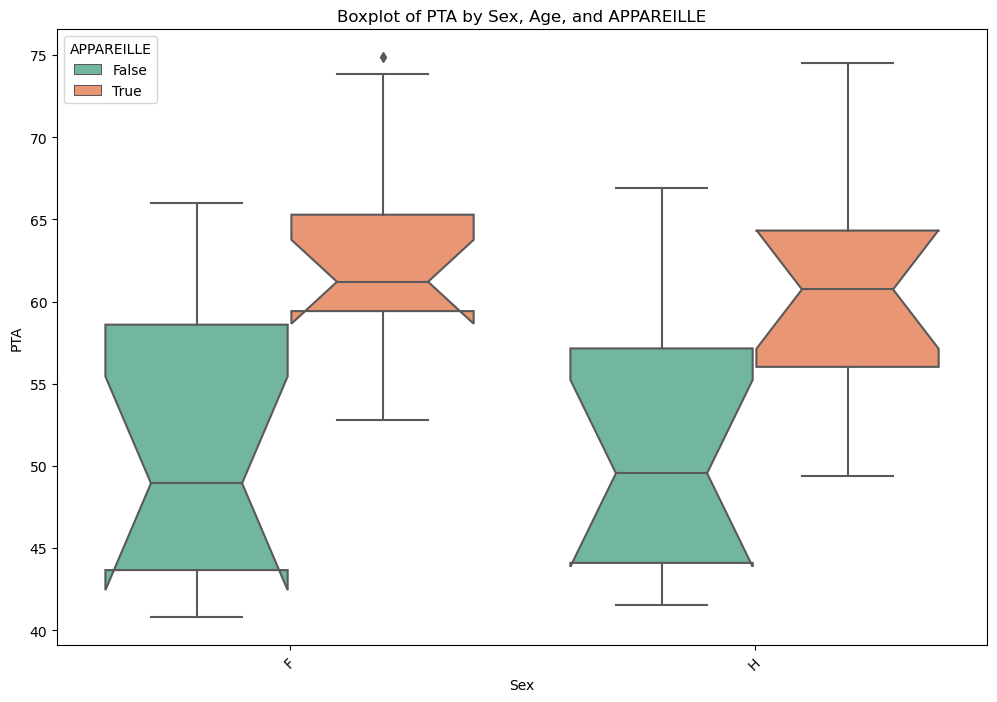

In [41]:
grouped_df = df_Ps_Tests_nodep_uniquecode.groupby(['SEXE', pd.cut(df_Ps_Tests_nodep_uniquecode['AGE'], bins=age_bins), 'APPAREILLE'])
mean_df = grouped_df['PTA_D'].mean().reset_index()

# Create the boxplot
plt.figure(figsize=(12, 8))
sn.boxplot(data=mean_df, x='SEXE', y='PTA_D', hue='APPAREILLE', hue_order=[False, True], 
            palette='Set2', notch=True)
plt.xlabel('Sex')
plt.ylabel('PTA')
plt.title('Boxplot of PTA by Sex, Age, and APPAREILLE')
plt.xticks(rotation=45)
plt.show()

In [42]:
# Define the age bin edges
age_bin_edges = [0, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Create age bins using the edges
df_Ps_Tests_nodep_uniquecode['age_bins'] = pd.cut(df_Ps_Tests_nodep_uniquecode['AGE'], bins=age_bin_edges)


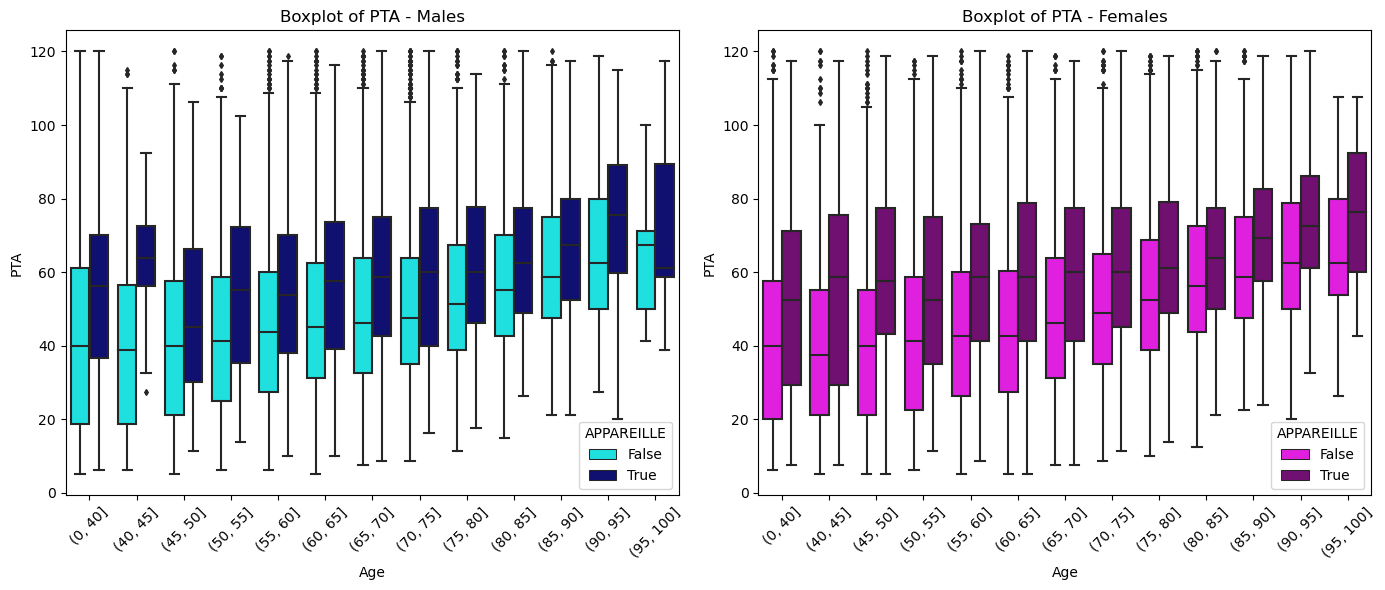

In [44]:
# Define custom color palette
custom_palette_males = {False: "cyan", True: "navy"}
custom_palette_females = {False: "magenta", True: "purple"}

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filter dataframe for males and create boxplot for PTA_D by APPAREILLE and age_bins
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'H'], 
            x='age_bins', y='PTA_D', hue='APPAREILLE', hue_order=[False, True],
            notch=False, palette=custom_palette_males, ax=axes[0], fliersize=3)
axes[0].set_title('Boxplot of PTA - Males')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('PTA')
axes[0].tick_params(axis='x', rotation=45)

# Filter dataframe for females and create boxplot for PTA_D by APPAREILLE and age_bins
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'F'], 
            x='age_bins', y='PTA_D', hue='APPAREILLE', hue_order=[False, True],
            notch=False, palette=custom_palette_females, ax=axes[1], fliersize=3)
axes[1].set_title('Boxplot of PTA - Females')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('PTA')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as PDF
plt.savefig('figs/boxplot_pta_by_gender_age.pdf')

# Show plots
plt.show()

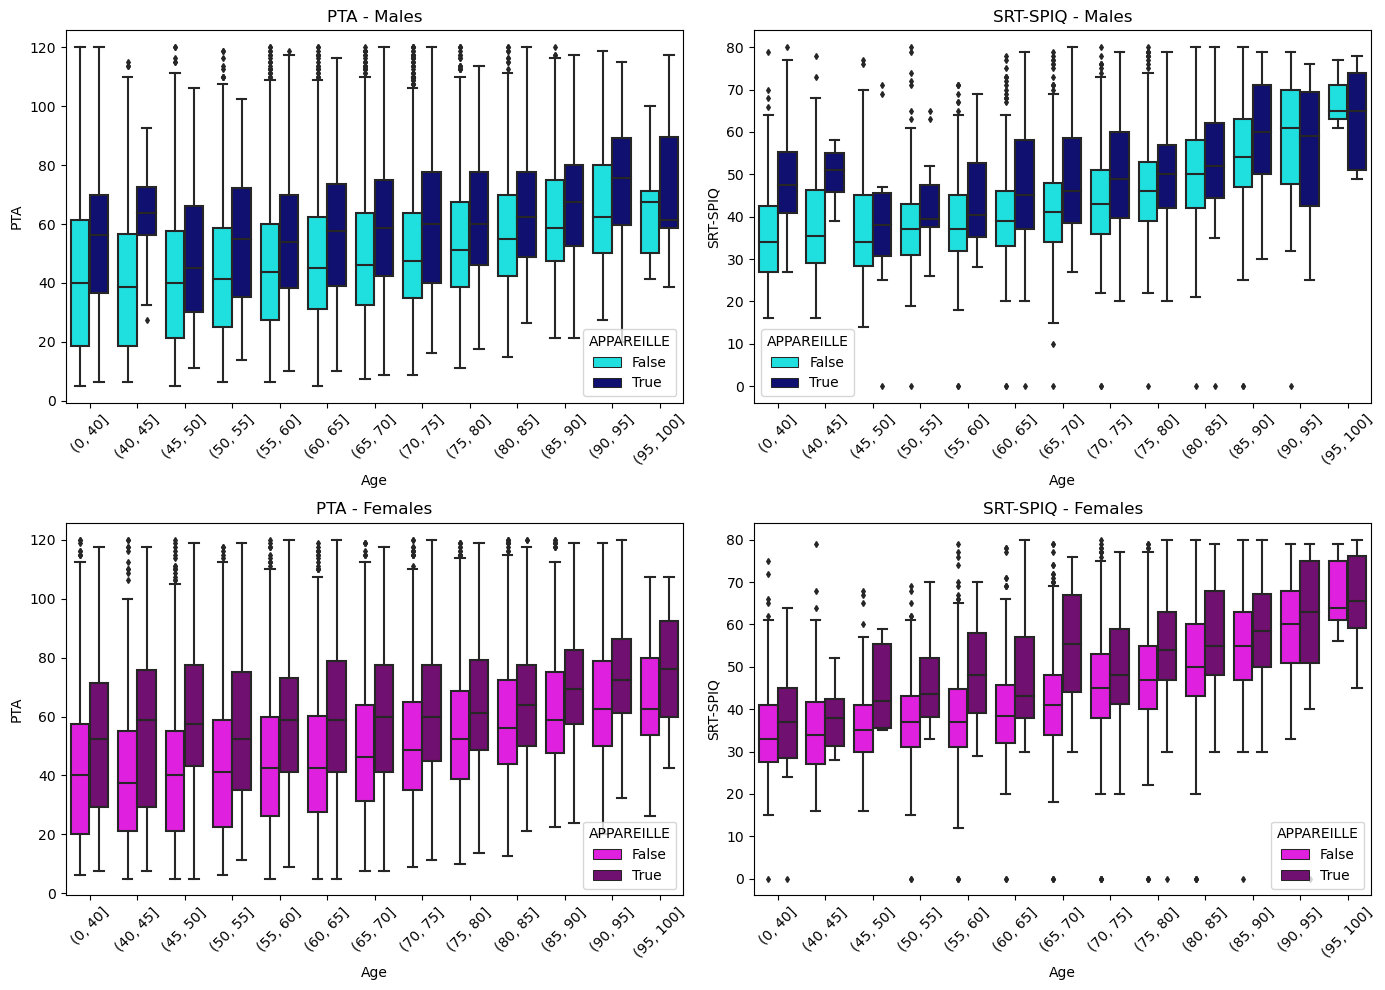

In [45]:
# Define custom color palette for males and females
custom_palette_males = {False: "cyan", True: "navy"}
custom_palette_females = {False: "magenta", True: "purple"}

# Create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Boxplot for PTA_D by APPAREILLE and age_bins for males
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'H'], 
           x='age_bins', y='PTA_D', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_males, ax=axes[0, 0], fliersize=3)
axes[0, 0].set_title('PTA - Males')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('PTA')
axes[0, 0].tick_params(axis='x', rotation=45)

# Boxplot for SRT_SPIQ_B by APPAREILLE and age_bins for males
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'H'], 
           x='age_bins', y='SRT_SPIQ_B', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_males, ax=axes[0, 1], fliersize=3)
axes[0, 1].set_title('SRT-SPIQ - Males')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('SRT-SPIQ')
axes[0, 1].tick_params(axis='x', rotation=45)

# Boxplot for PTA_D by APPAREILLE and age_bins for females
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'F'], 
           x='age_bins', y='PTA_D', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_females, ax=axes[1, 0], fliersize=3)
axes[1, 0].set_title('PTA - Females')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('PTA')
axes[1, 0].tick_params(axis='x', rotation=45)

# Boxplot for SRT_SPIQ_B by APPAREILLE and age_bins for females
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'F'], 
           x='age_bins', y='SRT_SPIQ_B', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_females, ax=axes[1, 1], fliersize=3)
axes[1, 1].set_title('SRT-SPIQ - Females')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('SRT-SPIQ')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as PDF
plt.savefig('figs/boxplot_pta_srt_by_gender_age.pdf')

# Show plots
plt.show()

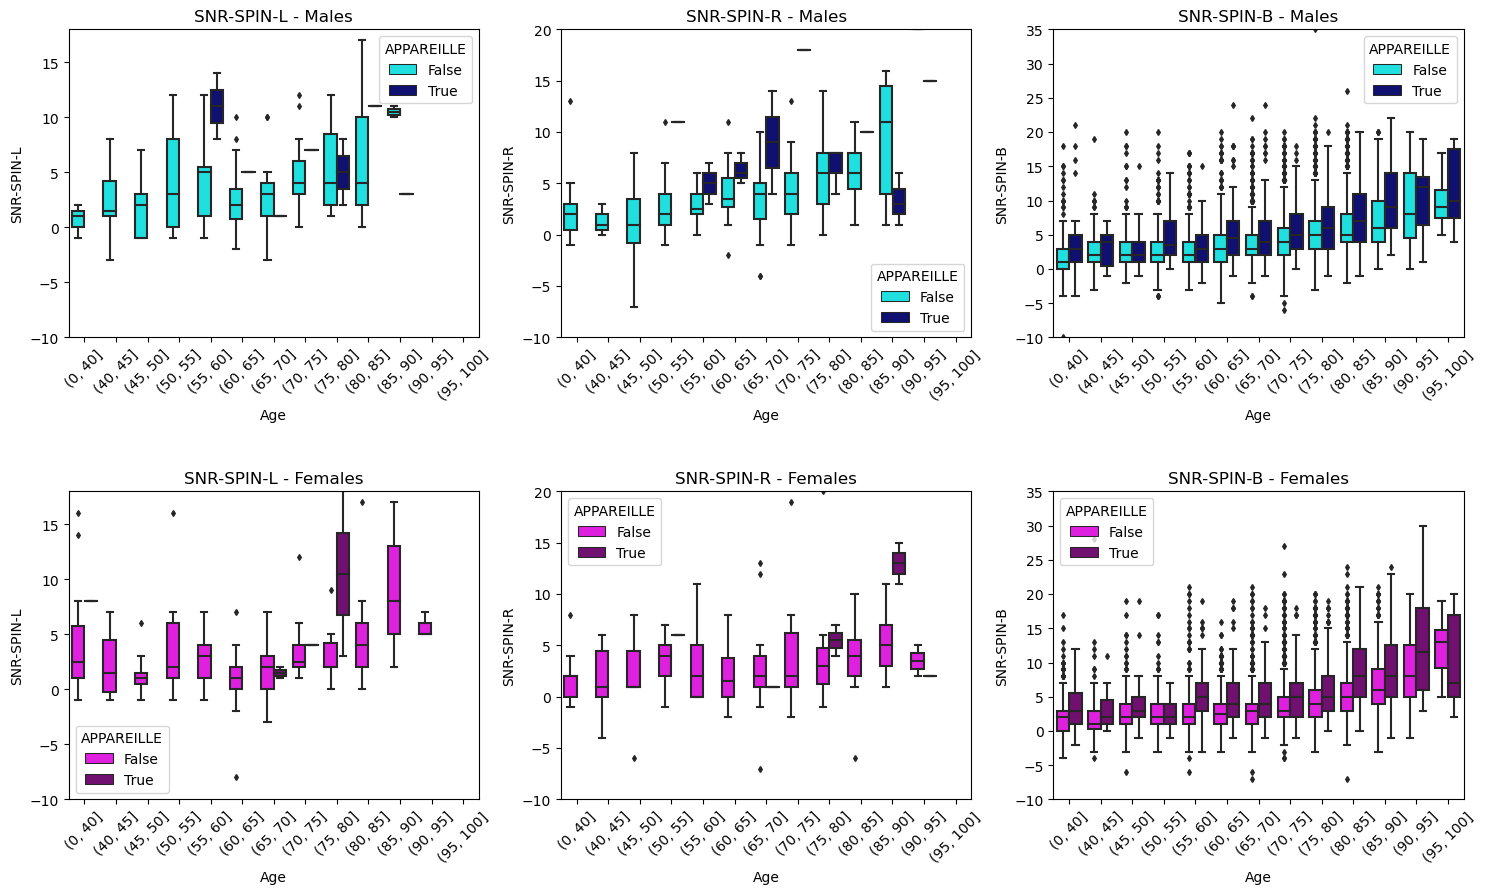

In [46]:
max_SNR_SPIN_G = df_Ps_Tests_nodep_uniquecode['SNR_SPIN_G'].max()
max_SNR_SPIN_D = df_Ps_Tests_nodep_uniquecode['SNR_SPIN_D'].max()
max_SNR_SPIN_B = df_Ps_Tests_nodep_uniquecode['SNR_SPIN_B'].max()

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Boxplot for SNR_SPIN_G by APPAREILLE and age_bins for males
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'H'], 
           x='age_bins', y='SNR_SPIN_G', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_males, ax=axes[0, 0], fliersize=3)
axes[0, 0].set_title('SNR-SPIN-L - Males')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('SNR-SPIN-L')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim(-10, max_SNR_SPIN_G)


# Boxplot for SNR_SPIN_D by APPAREILLE and age_bins for males
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'H'], 
           x='age_bins', y='SNR_SPIN_D', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_males, ax=axes[0, 1], fliersize=3)
axes[0, 1].set_title('SNR-SPIN-R - Males')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('SNR-SPIN-R')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(-10, max_SNR_SPIN_D)


# Boxplot for SNR_SPIN_B by APPAREILLE and age_bins for males
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'H'], 
           x='age_bins', y='SNR_SPIN_B', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_males, ax=axes[0, 2], fliersize=3)
axes[0, 2].set_title('SNR-SPIN-B - Males')
axes[0, 2].set_xlabel('Age')
axes[0, 2].set_ylabel('SNR-SPIN-B')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_ylim(-10, max_SNR_SPIN_B)


# Boxplot for SNR_SPIN_G by APPAREILLE and age_bins for females
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'F'], 
           x='age_bins', y='SNR_SPIN_G', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_females, ax=axes[1, 0], fliersize=3)
axes[1, 0].set_title('SNR-SPIN-L - Females')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('SNR-SPIN-L')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim(-10, max_SNR_SPIN_G)


# Boxplot for SNR_SPIN_D by APPAREILLE and age_bins for females
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'F'], 
           x='age_bins', y='SNR_SPIN_D', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_females, ax=axes[1, 1], fliersize=3)
axes[1, 1].set_title('SNR-SPIN-R - Females')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('SNR-SPIN-R')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim(-10, max_SNR_SPIN_D)


# Boxplot for SNR_SPIN_B by APPAREILLE and age_bins for females
sn.boxplot(data=df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['SEXE'] == 'F'], 
           x='age_bins', y='SNR_SPIN_B', hue='APPAREILLE', hue_order=[False, True],
           notch=False, palette=custom_palette_females, ax=axes[1, 2], fliersize=3)
axes[1, 2].set_title('SNR-SPIN-B - Females')
axes[1, 2].set_xlabel('Age')
axes[1, 2].set_ylabel('SNR-SPIN-B')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].set_ylim(-10, max_SNR_SPIN_B)

# Adjust layout to add space between upper and lower plots
plt.subplots_adjust(hspace=0.5)

# Save the plots as PDF
plt.savefig('figs/boxplot_snr_by_gender_age.pdf')
# Show plots
plt.show()

In [47]:
# Filter DataFrame for rows where APPAREILLE is FALSE
df_false_appareille = df_Ps_Tests_nodep_uniquecode[df_Ps_Tests_nodep_uniquecode['APPAREILLE'] == False]

# Define the order of HL levels
hl_order = ['Normal', 'Slight', 'Mild', 'Moderate', 'Moderately Severe', 'Severe', 'Profound']

In [48]:
sn.color_palette("viridis_r", len(hl_order)) 


[(0.668054, 0.861999, 0.196293),
 (0.360741, 0.785964, 0.387814),
 (0.153894, 0.680203, 0.504172),
 (0.128729, 0.563265, 0.551229),
 (0.174274, 0.445044, 0.557792),
 (0.231674, 0.318106, 0.544834),
 (0.279574, 0.170599, 0.479997)]

In [49]:
sn.cubehelix_palette(n_colors=len(hl_order), start=14, rot=0.3, hue=2.8)

[[0.678654243920552, 0.8809935438278096, 1.0],
 [0.38361078124273684, 0.8349246825829872, 1.0],
 [0.11164087878028928, 0.7995105492711806, 1.0],
 [0.0, 0.7493679563820719, 0.7851494937912101],
 [0.0, 0.6592539390305663, 0.5146789290050057],
 [0.0, 0.5164648054304939, 0.25535467869468687],
 [0.0, 0.3177095228672058, 0.06483964774891086]]

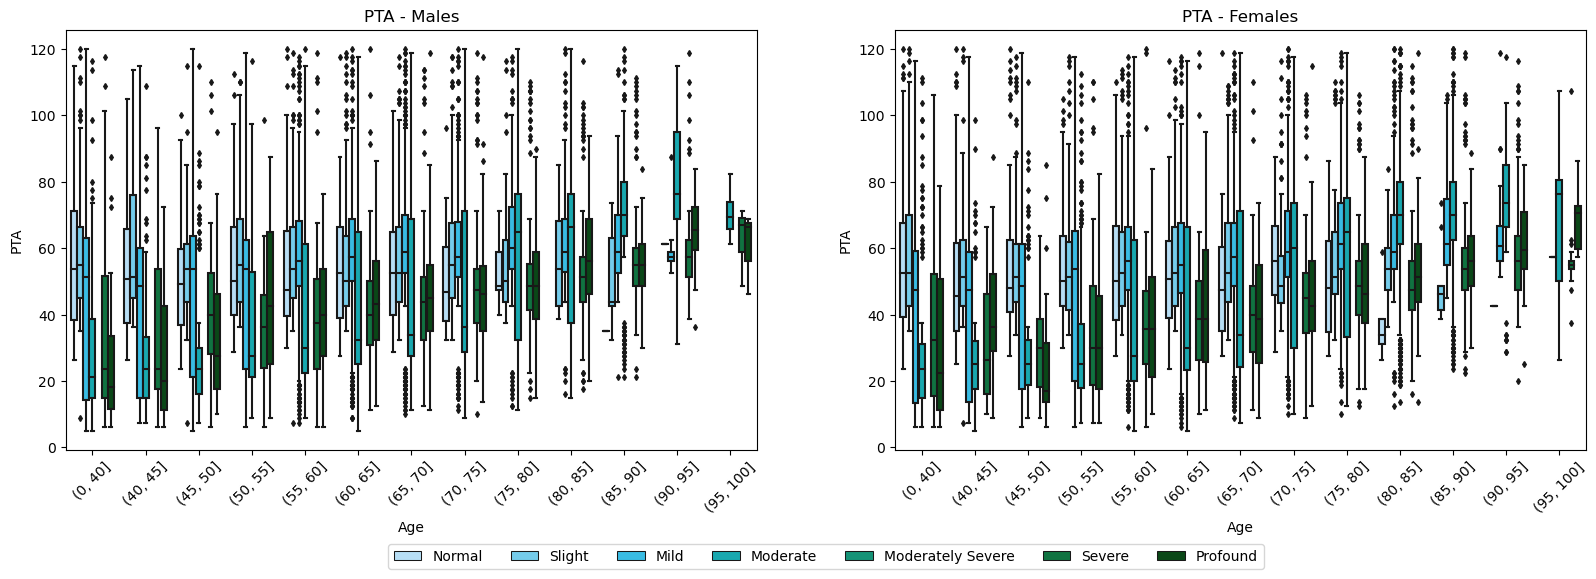

In [50]:
# Define custom color palette for males
custom_palette_males = sn.cubehelix_palette(n_colors=len(hl_order), start=14, rot=0.3, hue=2.8)

# Create subplots for boxplots
fig, axes = plt.subplots(1, 2, figsize=(19, 6))

# Boxplot for PTA by HL and age_bins for males with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'H'], 
           x='age_bins', y='PTA_D', hue='HL', hue_order=hl_order,
           notch=False, palette=custom_palette_males, ax=axes[0], fliersize=3)
axes[0].set_title('PTA - Males')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('PTA')
axes[0].tick_params(axis='x', rotation=45)

# Boxplot for PTA by HL and age_bins for females with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'F'], 
           x='age_bins', y='PTA_D', hue='HL', hue_order=hl_order,
           notch=False, palette=custom_palette_males, ax=axes[1], fliersize=3)
axes[1].set_title('PTA - Females')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('PTA')
axes[1].tick_params(axis='x', rotation=45)

# Remove individual legends
for ax in axes.flatten():
    ax.get_legend().remove()

# Add a legend at the bottom
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=7)

# Adjust layout
plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9)

# Save the plots as PDF
plt.savefig('figs/boxplot_pta_by_gender_age_HL.pdf')

# Show the plots
plt.show()

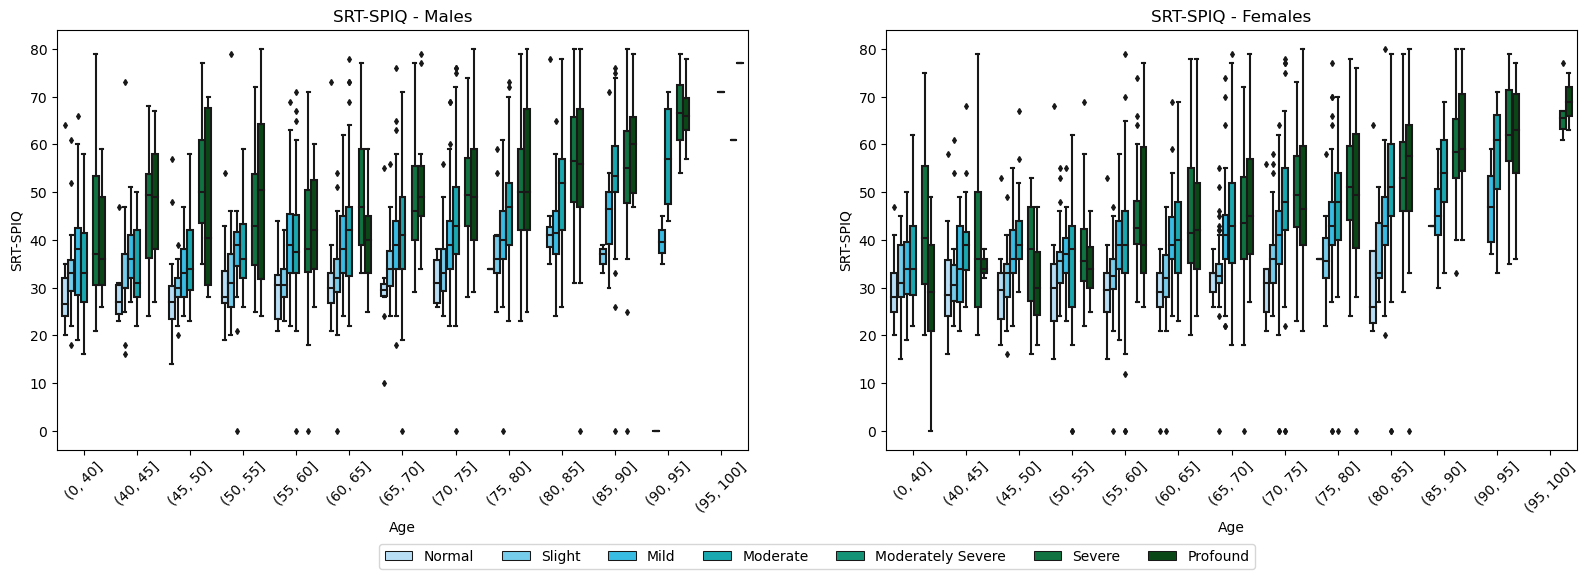

In [51]:
# Define custom color palette for males
custom_palette_males = sn.cubehelix_palette(n_colors=len(hl_order), start=14, rot=0.3, hue=2.8)

# Create subplots for boxplots
fig, axes = plt.subplots(1, 2, figsize=(19, 6))

# Boxplot for PTA by HL and age_bins for males with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'H'], 
           x='age_bins', y='SRT_SPIQ_B', hue='HL', hue_order=hl_order,
           notch=False, palette=custom_palette_males, ax=axes[0], fliersize=3)
axes[0].set_title('SRT-SPIQ - Males')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('SRT-SPIQ')
axes[0].tick_params(axis='x', rotation=45)

# Boxplot for PTA by HL and age_bins for females with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'F'], 
           x='age_bins', y='SRT_SPIQ_B', hue='HL', hue_order=hl_order,
           notch=False, palette=custom_palette_males, ax=axes[1],  fliersize=3)
axes[1].set_title('SRT-SPIQ - Females')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('SRT-SPIQ')
axes[1].tick_params(axis='x', rotation=45)

# Remove individual legends
for ax in axes.flatten():
    ax.get_legend().remove()

# Add a legend at the bottom
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=7)

# Adjust layout
#plt.tight_layout()
plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9)

# Save the plots as PDF
plt.savefig('figs/boxplot_srt_spiq_by_gender_age_HL.pdf')

# Show the plots
plt.show()

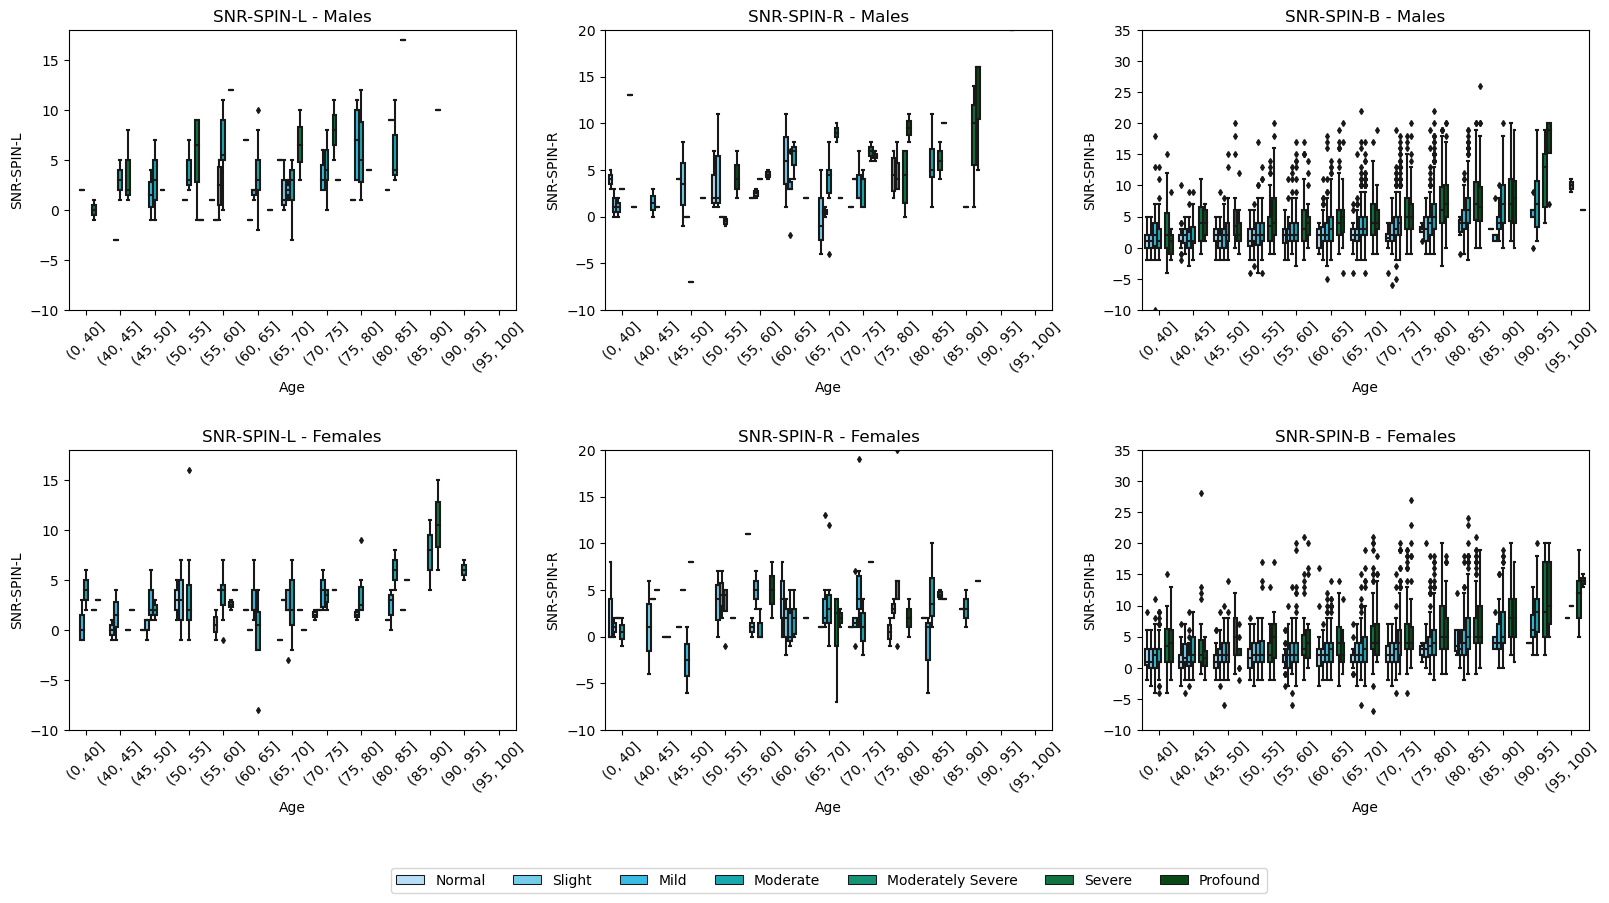

In [52]:
# Define custom color palette for males
custom_palette_males = sn.cubehelix_palette(n_colors=len(hl_order), start=14, rot=0.3, hue=2.8) #sn.color_palette("Set2", n_colors=len(hl_order))

# Create subplots for boxplots
fig, axes = plt.subplots(2, 3, figsize=(19, 10))

# Boxplot for SNR_SPIN_G by HL and age_bins for males with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'H'], 
            x='age_bins', y='SNR_SPIN_G', hue='HL', hue_order=hl_order,
            notch=False, palette=custom_palette_males, ax=axes[0, 0],  fliersize=3)
axes[0, 0].set_title('SNR-SPIN-L - Males')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('SNR-SPIN-L')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim(-10, max_SNR_SPIN_G)

# Boxplot for SNR_SPIN_D by HL and age_bins for males with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'H'], 
            x='age_bins', y='SNR_SPIN_D', hue='HL', hue_order=hl_order,
            notch=False, palette=custom_palette_males, ax=axes[0, 1],  fliersize=3)
axes[0, 1].set_title('SNR-SPIN-R - Males')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('SNR-SPIN-R')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(-10, max_SNR_SPIN_D)

# Boxplot for SNR_SPIN_B by HL and age_bins for males with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'H'], 
            x='age_bins', y='SNR_SPIN_B', hue='HL', hue_order=hl_order,
            notch=False, palette=custom_palette_males, ax=axes[0, 2],  fliersize=3)
axes[0, 2].set_title('SNR-SPIN-B - Males')
axes[0, 2].set_xlabel('Age')
axes[0, 2].set_ylabel('SNR-SPIN-B')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_ylim(-10, max_SNR_SPIN_B)

# Boxplot for SNR_SPIN_G by HL and age_bins for females with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'F'], 
            x='age_bins', y='SNR_SPIN_G', hue='HL', hue_order=hl_order,
            notch=False, palette=custom_palette_males, ax=axes[1, 0],  fliersize=3)
axes[1, 0].set_title('SNR-SPIN-L - Females')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('SNR-SPIN-L')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim(-10, max_SNR_SPIN_G)


# Boxplot for SNR_SPIN_D by HL and age_bins for females with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'F'], 
            x='age_bins', y='SNR_SPIN_D', hue='HL', hue_order=hl_order,
            notch=False, palette=custom_palette_males, ax=axes[1, 1],  fliersize=3)
axes[1, 1].set_title('SNR-SPIN-R - Females')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('SNR-SPIN-R')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim(-10, max_SNR_SPIN_D)

# Boxplot for SNR_SPIN_B by HL and age_bins for females with APPAREILLE = FALSE
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'F'], 
            x='age_bins', y='SNR_SPIN_B', hue='HL', hue_order=hl_order,
            notch=False, palette=custom_palette_males, ax=axes[1, 2],  fliersize=3)
axes[1, 2].set_title('SNR-SPIN-B - Females')
axes[1, 2].set_xlabel('Age')
axes[1, 2].set_ylabel('SNR-SPIN-B')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].set_ylim(-10, max_SNR_SPIN_B)

# Remove individual legends
for ax in axes.flatten():
    ax.get_legend().remove()

# Add a legend at the bottom
handles, labels = axes[1, 2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.03), ncol=7)
    
# Adjust layout
#plt.tight_layout()
plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, hspace=0.5, wspace=0.2)


# Save the plots as PDF
plt.savefig('figs/boxplot_snr_by_gender_age_HL.pdf')


# Show the plots
plt.show()

## COSI Plot

In [53]:
sn.color_palette("tab10", n_colors=9)


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

In [54]:
sn.color_palette("tab20c", n_colors=9)

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235)]

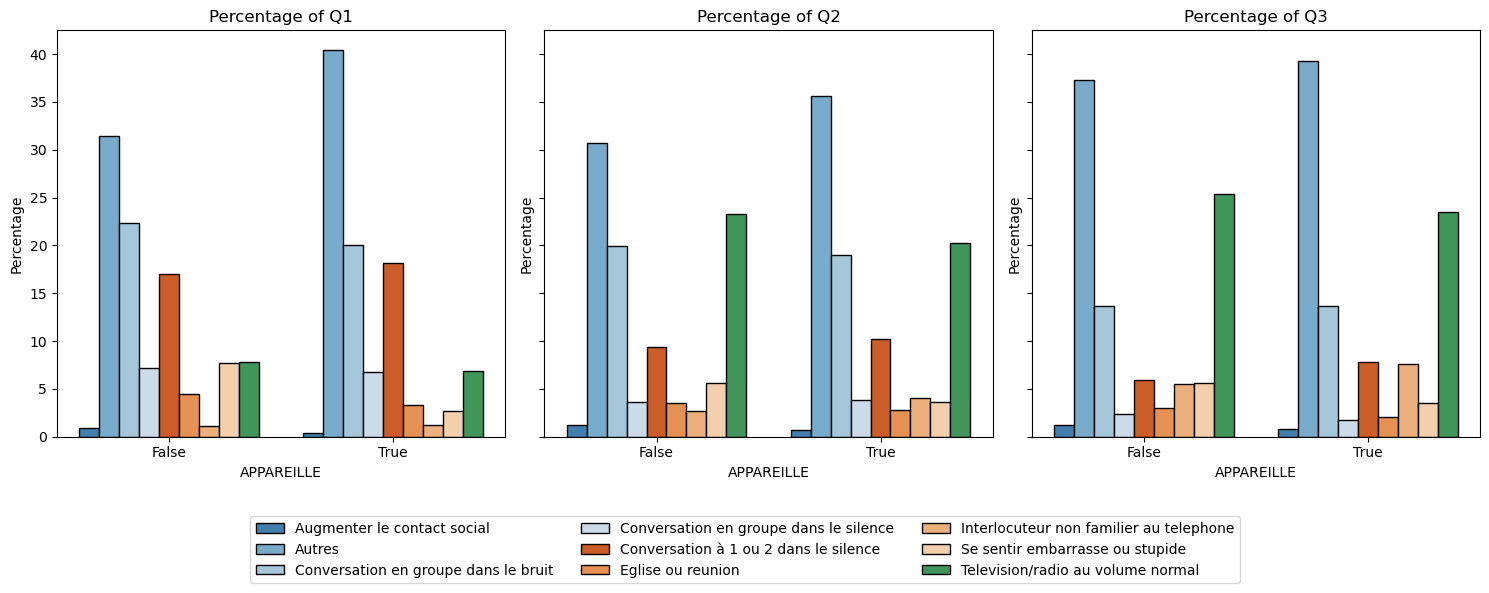

In [55]:
# Group by APPAREILLE
grouped_appdp_priority = df_Ps_Tests_nodep.groupby('APPAREILLE')

plot_pal = sn.color_palette("tab20c", n_colors=9)

# Define the labels to count
label_columns = ['Label_Q1', 'Label_Q2', 'Label_Q3']

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, label in enumerate(label_columns):
    # Count occurrences of each label for each group
    label_counts = grouped_appdp_priority[label].value_counts().unstack()
    
    # Normalize counts to get percentages
    label_counts_percent = label_counts.div(label_counts.sum(axis=1), axis=0) * 100
    
    # Stack the data for better visualization
    stacked_data = label_counts_percent.stack().reset_index().rename(columns={0: 'Percentage', 'APPAREILLE': 'Appareille', 'level_1': label[6:]})
    
    # Use Seaborn's barplot for a fancier visualization
    sn.barplot(data=stacked_data, x='Appareille', y='Percentage', hue=label, 
               ax=axs[i], edgecolor='black', palette=plot_pal )
    axs[i].set_xlabel('APPAREILLE')
    axs[i].set_ylabel('Percentage')
    axs[i].set_title(f'Percentage of {label[6:]}')
    axs[i].legend_.remove()


# Create a single legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.19), ncol=3)

plt.tight_layout()

# Save the plots as PDF
plt.savefig('figs/barplot_labels_COSI.pdf')

plt.show()


### Verify numbers are correct + percentage missing to be presented in the Appendix

In [127]:
df_Ps_Tests_nodep_uniquecode[(df_Ps_Tests_nodep_uniquecode['APPAREILLE'] == False) & (df_Ps_Tests_nodep_uniquecode['SEXE'] == 'F')].groupby([ 'Label_Q1'])[['CUSTOMER_CODE']].count()  #Just to  see - play with the Label_Q to see the other counts

,CUSTOMER_CODE
Label_Q1,
Augmenter le contact social,126
Autres,4012
Conversation en groupe dans le bruit,2597
Conversation en groupe dans le silence,935
Conversation à 1 ou 2 dans le silence,1946
Eglise ou reunion,539
Interlocuteur non familier au telephone,204
Se sentir embarrasse ou stupide,1047
Television/radio au volume normal,946


In [128]:
df_Ps_Tests_nodep_uniquecode[(df_Ps_Tests_nodep_uniquecode['APPAREILLE'] == False) & (df_Ps_Tests_nodep_uniquecode['SEXE'] == 'F')].groupby([ 'age_bins'])[['CUSTOMER_CODE']].count()  #CHECK --> correct

,CUSTOMER_CODE
age_bins,
"(0, 40]",690
"(40, 45]",349
"(45, 50]",533
"(50, 55]",698
"(55, 60]",1009
"(60, 65]",1152
"(65, 70]",1717
"(70, 75]",1904
"(75, 80]",1456


In [135]:
 df_Ps_Tests_nodep_uniquecode.groupby('age_bins')[['PTA_D', 'SNR_SPIN_G', 'SNR_SPIN_D', 'SNR_SPIN_B', 'SRT_SPIQ_B']].apply(lambda x: x.isnull().sum())/df_Ps_Tests_nodep_uniquecode.groupby('age_bins')[['PTA_D', 'SNR_SPIN_G', 'SNR_SPIN_D', 'SNR_SPIN_B', 'SRT_SPIQ_B']].count()

,PTA_D,SNR_SPIN_G,SNR_SPIN_D,SNR_SPIN_B,SRT_SPIQ_B
age_bins,,,,,
"(0, 40]",0.0,70.333333,63.200000,0.868996,2.810089
"(40, 45]",0.0,47.928571,67.500000,0.658596,2.805556
"(45, 50]",0.0,58.000000,80.692308,0.621374,2.662069
"(50, 55]",0.0,68.545455,51.758621,0.661238,3.069149
"(55, 60]",0.0,62.324324,92.720000,0.650000,2.626935
"(60, 65]",0.0,82.527778,80.270270,0.625405,2.508751
"(65, 70]",0.0,94.688889,90.617021,0.672883,2.332817
"(70, 75]",0.0,119.487179,91.137255,0.655743,2.225120
"(75, 80]",0.0,102.722222,102.722222,0.728704,2.096186


In [137]:
df_Ps_Tests_nodep_uniquecode.groupby('Label_Q1')[['PTA_D', 'SNR_SPIN_G', 'SNR_SPIN_D', 'SNR_SPIN_B', 'SRT_SPIQ_B']].apply(lambda x: x.isnull().sum())/df_Ps_Tests_nodep_uniquecode.groupby('Label_Q1')[['PTA_D', 'SNR_SPIN_G', 'SNR_SPIN_D', 'SNR_SPIN_B', 'SRT_SPIQ_B']].count()


,PTA_D,SNR_SPIN_G,SNR_SPIN_D,SNR_SPIN_B,SRT_SPIQ_B
Label_Q1,,,,,
Augmenter le contact social,0.0,82.000000,123.500000,0.556250,1.305556
Autres,0.0,108.953488,93.560000,0.804236,2.599543
Conversation en groupe dans le bruit,0.0,68.521739,91.695652,0.601803,2.149188
Conversation en groupe dans le silence,0.0,81.920000,61.818182,0.948308,3.179435
Conversation à 1 ou 2 dans le silence,0.0,159.516129,87.857143,0.818713,2.028606
Eglise ou reunion,0.0,47.653846,65.578947,0.533333,2.504155
Interlocuteur non familier au telephone,0.0,111.333333,66.400000,0.841530,2.786517
Se sentir embarrasse ou stupide,0.0,93.090909,128.375000,0.674757,1.969871
Television/radio au volume normal,0.0,129.588235,95.521739,0.833196,2.338346


In [138]:
df_Ps_Tests_nodep_uniquecode.groupby('Label_Q2')[['PTA_D', 'SNR_SPIN_G', 'SNR_SPIN_D', 'SNR_SPIN_B', 'SRT_SPIQ_B']].apply(lambda x: x.isnull().sum())/df_Ps_Tests_nodep_uniquecode.groupby('Label_Q2')[['PTA_D', 'SNR_SPIN_G', 'SNR_SPIN_D', 'SNR_SPIN_B', 'SRT_SPIQ_B']].count()


,PTA_D,SNR_SPIN_G,SNR_SPIN_D,SNR_SPIN_B,SRT_SPIQ_B
Label_Q2,,,,,
Augmenter le contact social,0.0,107.666667,80.500000,0.743316,2.165049
Autres,0.0,93.086022,85.633663,0.764469,2.391473
Conversation en groupe dans le bruit,0.0,71.025974,69.202532,0.644234,2.170955
Conversation en groupe dans le silence,0.0,100.700000,126.125000,0.952015,2.852273
Conversation à 1 ou 2 dans le silence,0.0,93.428571,119.181818,0.714656,1.934517
Eglise ou reunion,0.0,105.666667,95.000000,0.571195,2.779528
Interlocuteur non familier au telephone,0.0,98.250000,55.714286,0.927184,2.497797
Se sentir embarrasse ou stupide,0.0,92.250000,148.200000,0.682074,2.315556
Television/radio au volume normal,0.0,132.187500,97.353846,0.782766,2.364737


In [139]:
df_Ps_Tests_nodep_uniquecode.groupby('Label_Q3')[['PTA_D', 'SNR_SPIN_G', 'SNR_SPIN_D', 'SNR_SPIN_B', 'SRT_SPIQ_B']].apply(lambda x: x.isnull().sum())/df_Ps_Tests_nodep_uniquecode.groupby('Label_Q3')[['PTA_D', 'SNR_SPIN_G', 'SNR_SPIN_D', 'SNR_SPIN_B', 'SRT_SPIQ_B']].count()


,PTA_D,SNR_SPIN_G,SNR_SPIN_D,SNR_SPIN_B,SRT_SPIQ_B
Label_Q3,,,,,
Augmenter le contact social,0.0,75.500000,152.000000,0.758621,2.187500
Autres,0.0,106.272727,83.285714,0.579652,2.021767
Conversation en groupe dans le bruit,0.0,113.466667,77.045455,0.579577,2.167897
Conversation en groupe dans le silence,0.0,94.000000,30.666667,0.887417,2.607595
Conversation à 1 ou 2 dans le silence,0.0,95.125000,152.800000,0.605428,2.204167
Eglise ou reunion,0.0,60.666667,60.666667,0.468254,1.913386
Interlocuteur non familier au telephone,0.0,119.833333,79.555556,0.755448,2.356481
Se sentir embarrasse ou stupide,0.0,66.700000,83.625000,0.854795,3.339744
Television/radio au volume normal,0.0,84.702703,116.444444,0.599899,2.025763


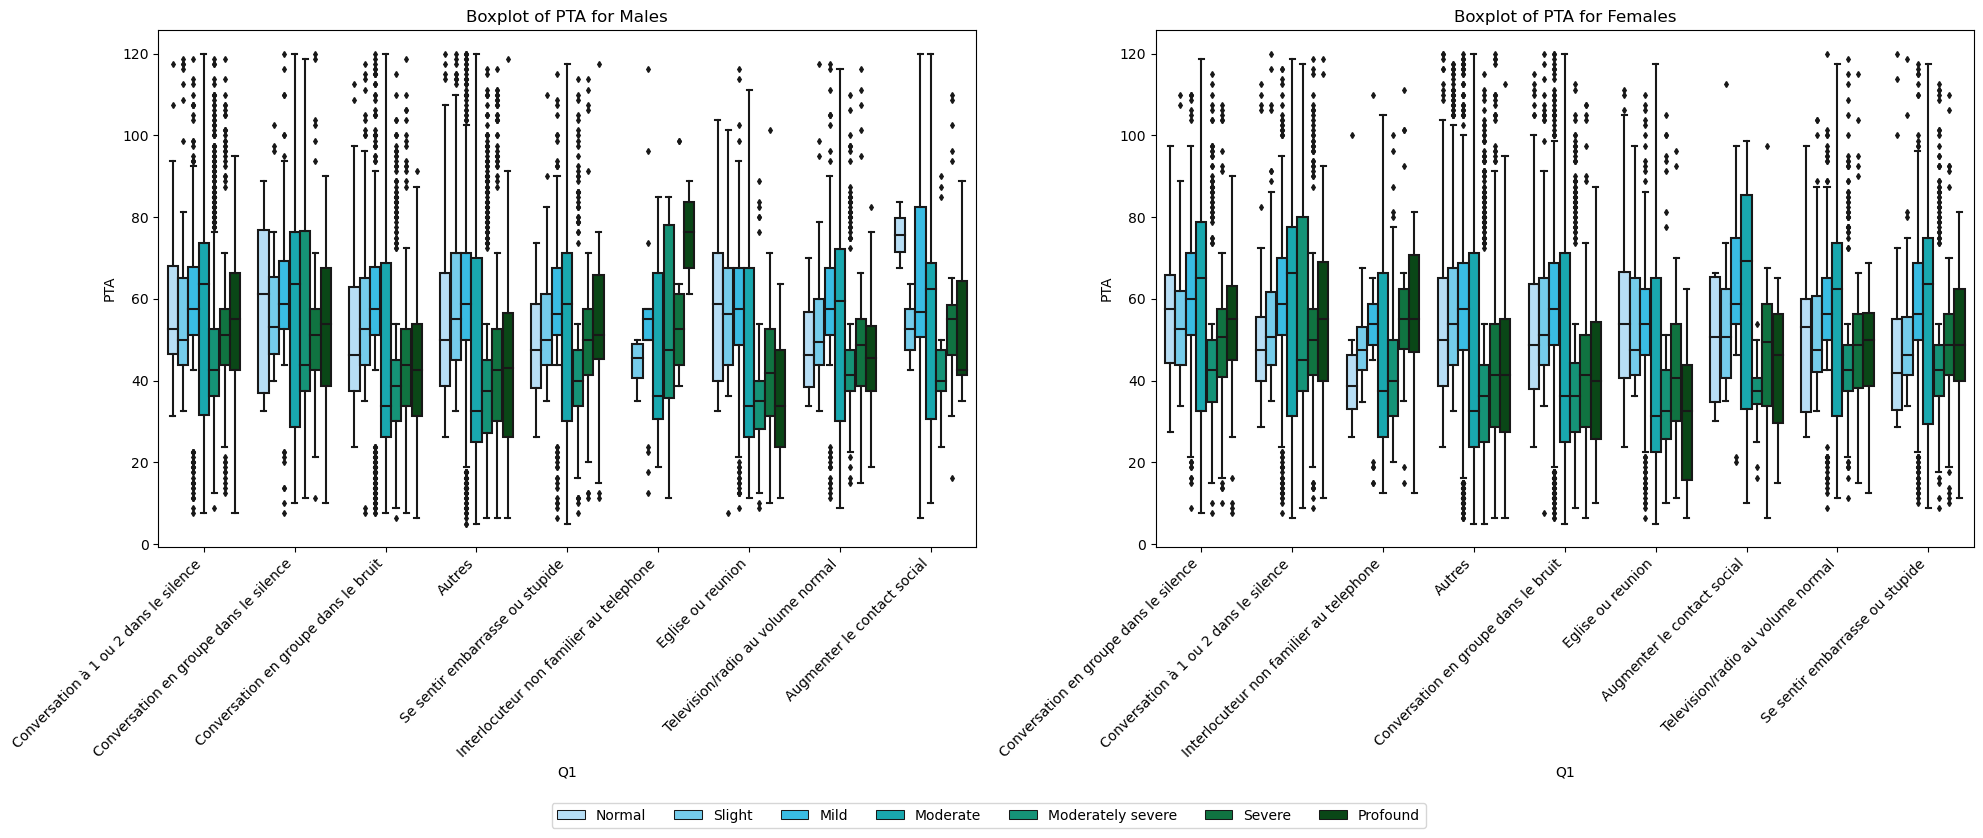

In [56]:
# Create a figure and axes objects
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot boxplot for males (Homme)
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'H'],
           x='Label_Q1', y='PTA_D', hue='HL', notch=False, 
           palette=custom_palette_males,  fliersize=3, ax=axes[0])
axes[0].set_title('Boxplot of PTA for Males')
axes[0].set_xlabel('Q1')
axes[0].set_ylabel('PTA')
axes[0].tick_params(axis='x', rotation=45)


# Plot boxplot for females (Femme)
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'F'],
           x='Label_Q1', y='PTA_D', hue='HL', notch=False, 
           palette=custom_palette_males,  fliersize=3, ax=axes[1])
axes[1].set_title('Boxplot of PTA for Females')
axes[1].set_xlabel('Q1')
axes[1].set_ylabel('PTA')
axes[1].tick_params(axis='x', rotation=45)



for tick in axes[0].get_xticklabels():
    tick.set_horizontalalignment('right')

for tick in axes[1].get_xticklabels():
    tick.set_horizontalalignment('right')

# Remove individual legends
for ax in axes.flatten():
    ax.get_legend().remove()

# Set legend for the first plot only
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=7)

plt.tight_layout()
plt.show()


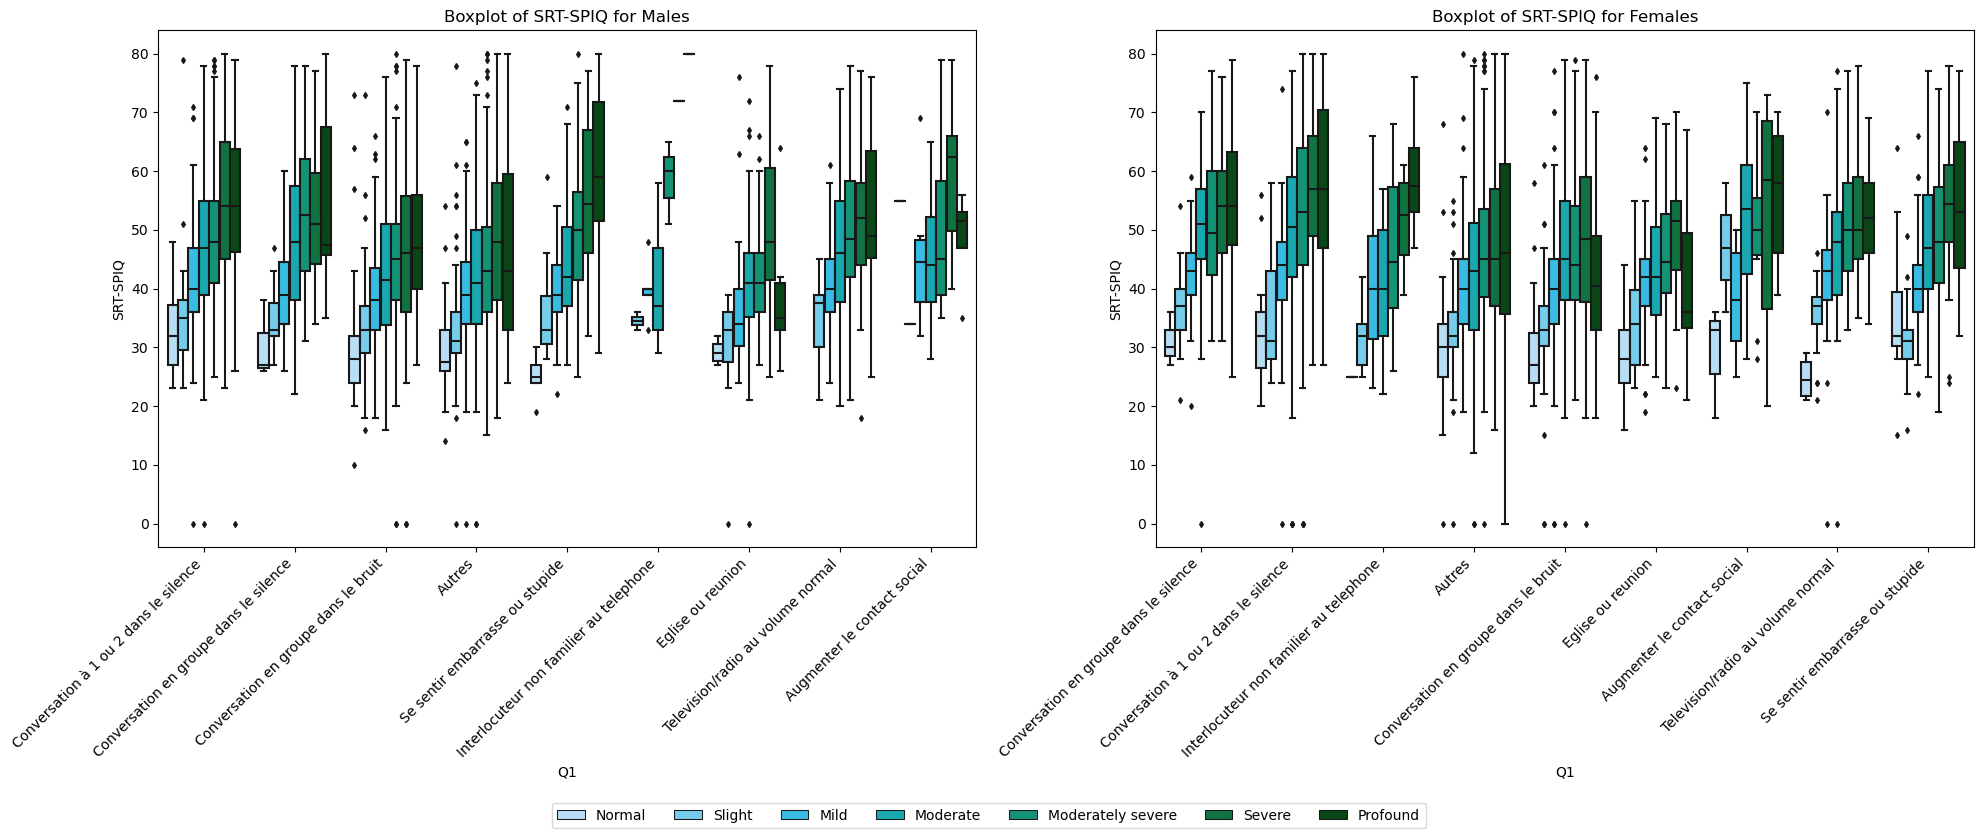

In [58]:
# Create a figure and axes objects
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot boxplot for males (Homme)
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'H'],
           x='Label_Q1', y='SRT_SPIQ_B', hue='HL', notch=False, 
           palette=custom_palette_males,  fliersize=3, ax=axes[0])
axes[0].set_title('Boxplot of SRT-SPIQ for Males')
axes[0].set_xlabel('Q1')
axes[0].set_ylabel('SRT-SPIQ')
axes[0].tick_params(axis='x', rotation=45)


# Plot boxplot for females (Femme)
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'F'],
           x='Label_Q1', y='SRT_SPIQ_B', hue='HL', notch=False, 
           palette=custom_palette_males,  fliersize=3, ax=axes[1])
axes[1].set_title('Boxplot of SRT-SPIQ for Females')
axes[1].set_xlabel('Q1')
axes[1].set_ylabel('SRT-SPIQ')
axes[1].tick_params(axis='x', rotation=45)



for tick in axes[0].get_xticklabels():
    tick.set_horizontalalignment('right')

for tick in axes[1].get_xticklabels():
    tick.set_horizontalalignment('right')

# Remove individual legends
for ax in axes.flatten():
    ax.get_legend().remove()

# Set legend for the first plot only
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=7)

plt.tight_layout()
plt.show()

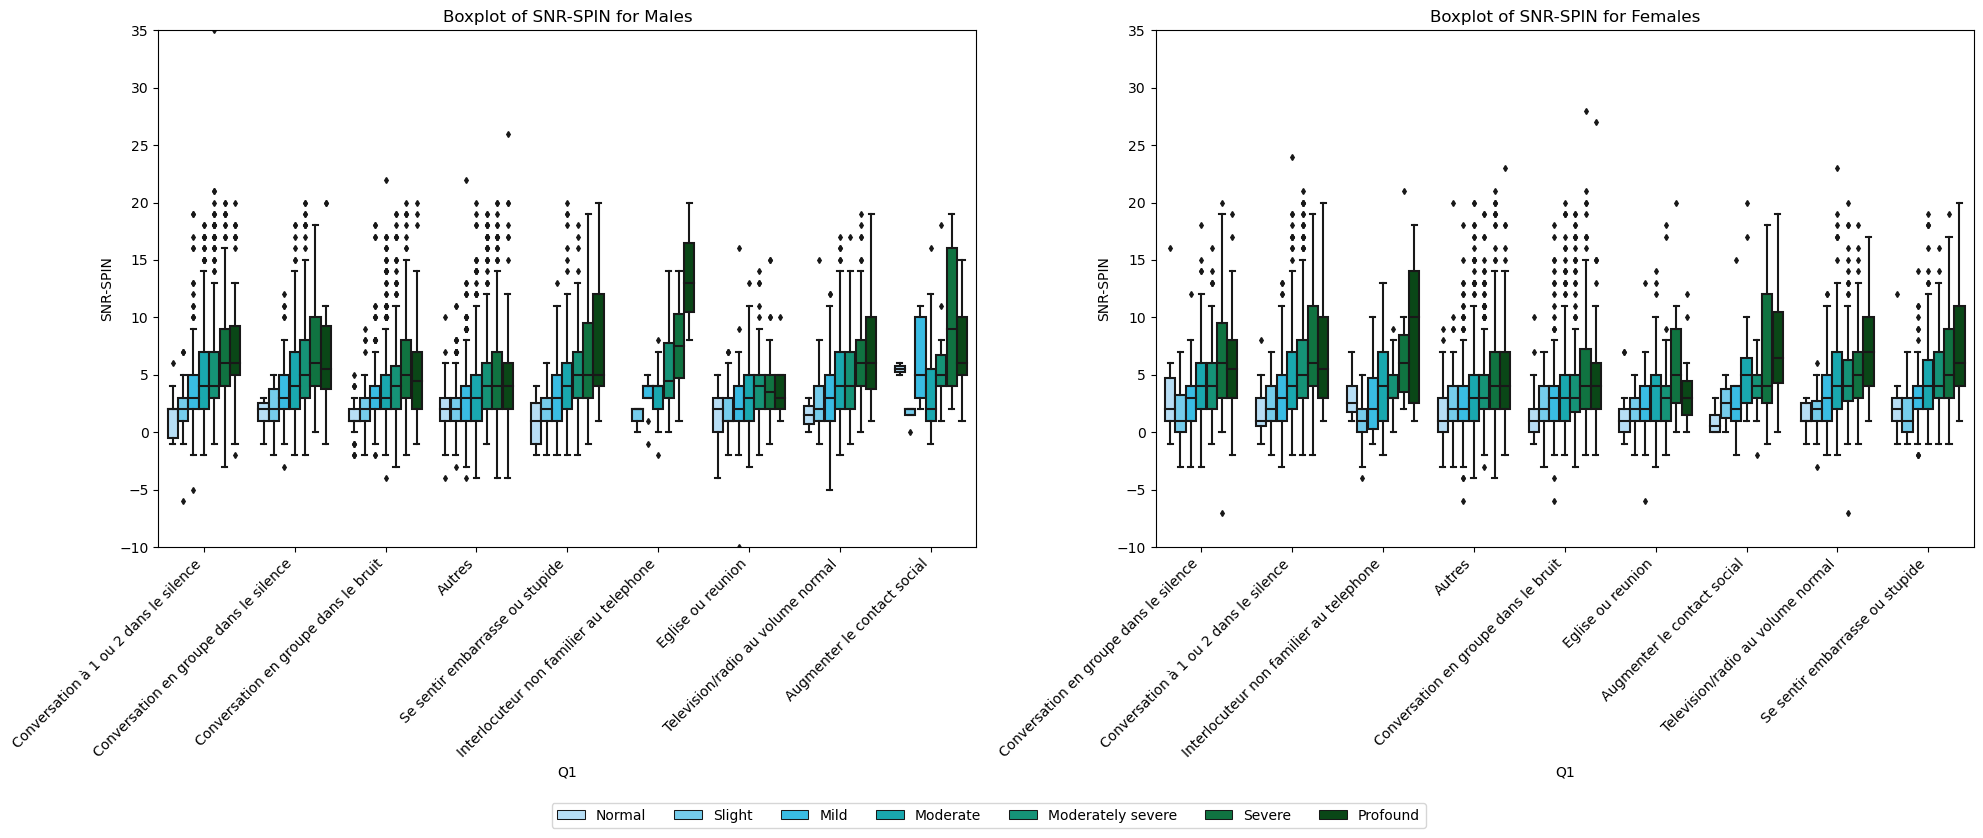

In [60]:
# Create a figure and axes objects
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot boxplot for males (Homme)
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'H'],
           x='Label_Q1', y='SNR_SPIN_B', hue='HL', notch=False, 
           palette=custom_palette_males,  fliersize=3, ax=axes[0])
axes[0].set_title('Boxplot of SNR-SPIN for Males')
axes[0].set_xlabel('Q1')
axes[0].set_ylabel('SNR-SPIN')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(-10, max_SNR_SPIN_B)



# Plot boxplot for females (Femme)
sn.boxplot(data=df_false_appareille[df_false_appareille['SEXE'] == 'F'],
           x='Label_Q1', y='SNR_SPIN_B', hue='HL', notch=False, 
           palette=custom_palette_males,  fliersize=3, ax=axes[1])
axes[1].set_title('Boxplot of SNR-SPIN for Females')
axes[1].set_xlabel('Q1')
axes[1].set_ylabel('SNR-SPIN')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(-10, max_SNR_SPIN_B)




for tick in axes[0].get_xticklabels():
    tick.set_horizontalalignment('right')

for tick in axes[1].get_xticklabels():
    tick.set_horizontalalignment('right')

# Remove individual legends
for ax in axes.flatten():
    ax.get_legend().remove()

# Set legend for the first plot only
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=7)

plt.tight_layout()
plt.show()

## RTSNE

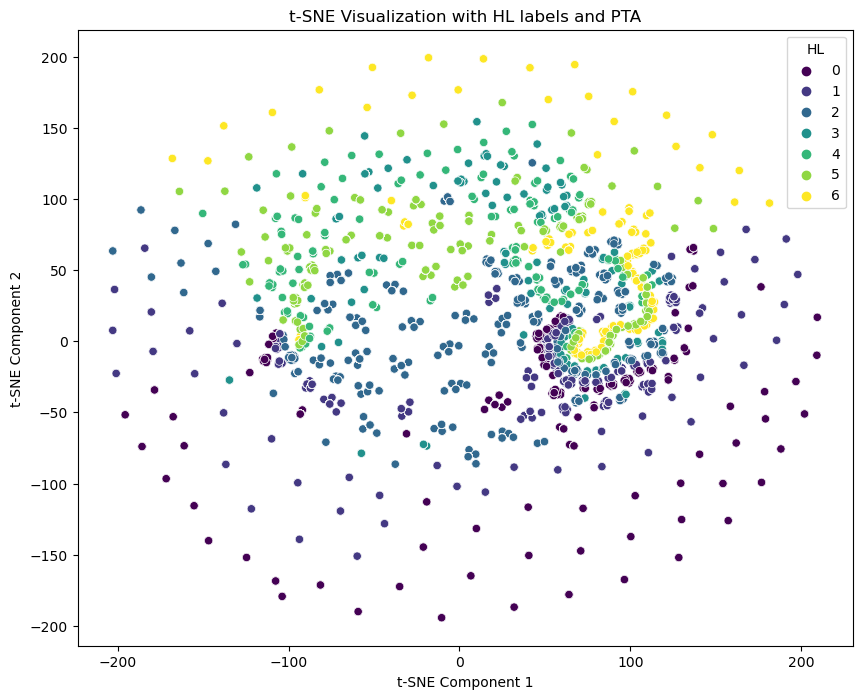

In [414]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'PTA_D']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])

# Drop rows with NaN values in 'PTA_D' column
new_df.dropna(subset=['HL_encoded', 'PTA_D'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'PTA_D']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and PTA')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

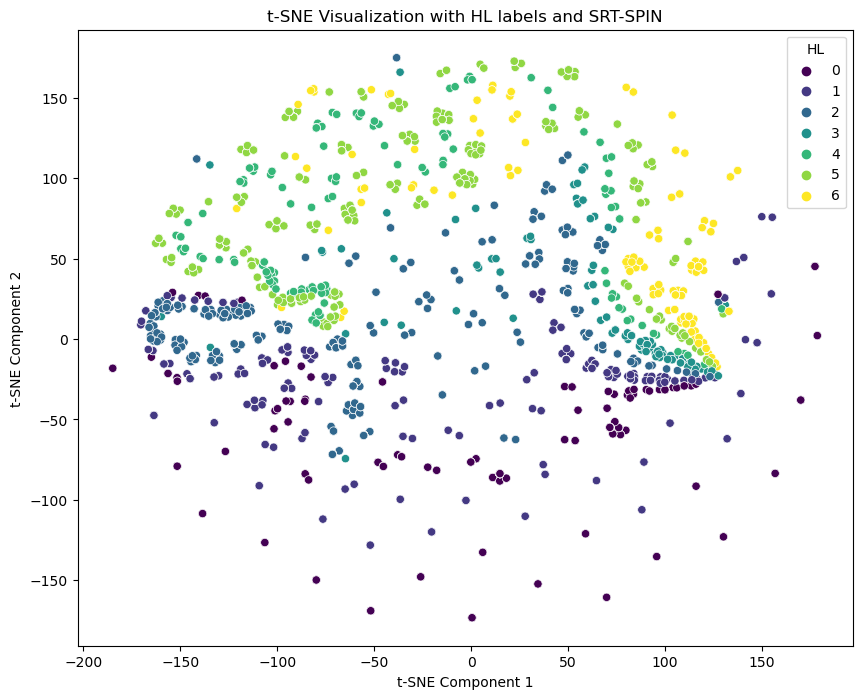

In [416]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'SRT_SPIQ_B']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])

# Drop rows with NaN values in 'SRT_SPIQ_B' column
new_df.dropna(subset=['HL_encoded', 'SRT_SPIQ_B'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'SRT_SPIQ_B']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and SRT-SPIN')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

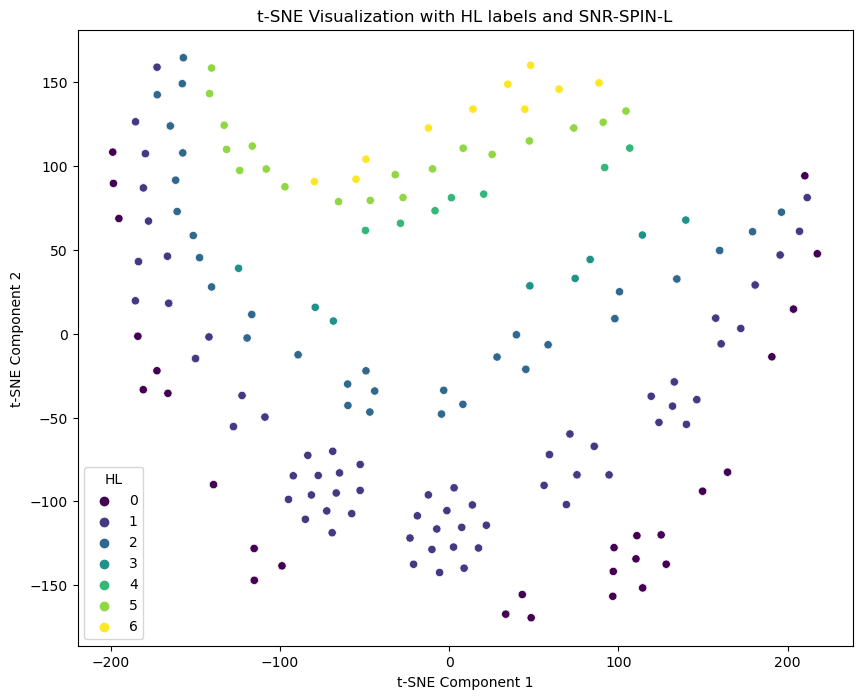

In [417]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'SNR_SPIN_G']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])

# Drop rows with NaN values in 'SNR_SPIN_G' column
new_df.dropna(subset=['HL_encoded', 'SNR_SPIN_G'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'SNR_SPIN_G']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and SNR-SPIN-L')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

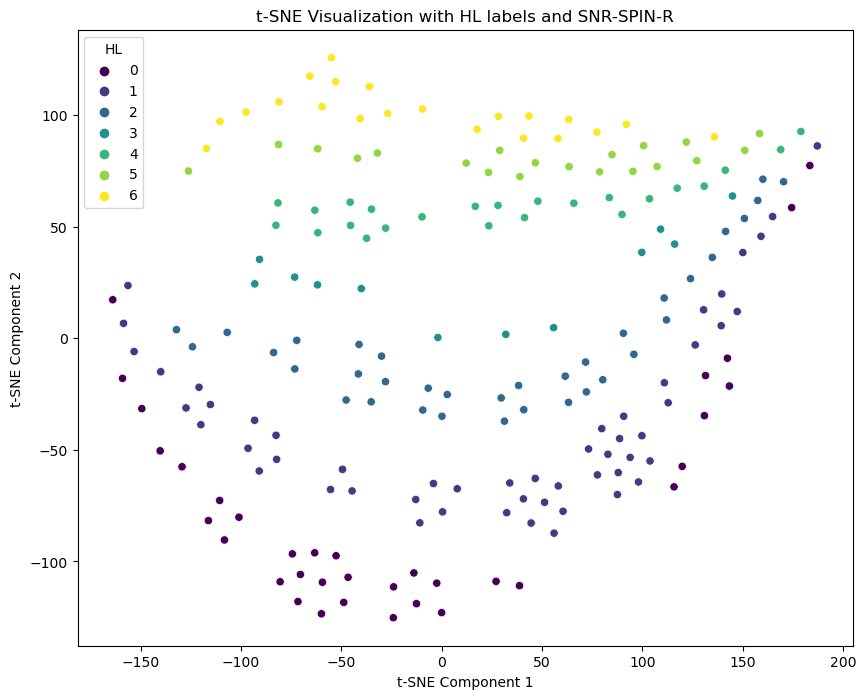

In [418]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'SNR_SPIN_D']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])

# Drop rows with NaN values in 'SNR_SPIN_D' column
new_df.dropna(subset=['HL_encoded', 'SNR_SPIN_D'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'SNR_SPIN_D']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and SNR-SPIN-R')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

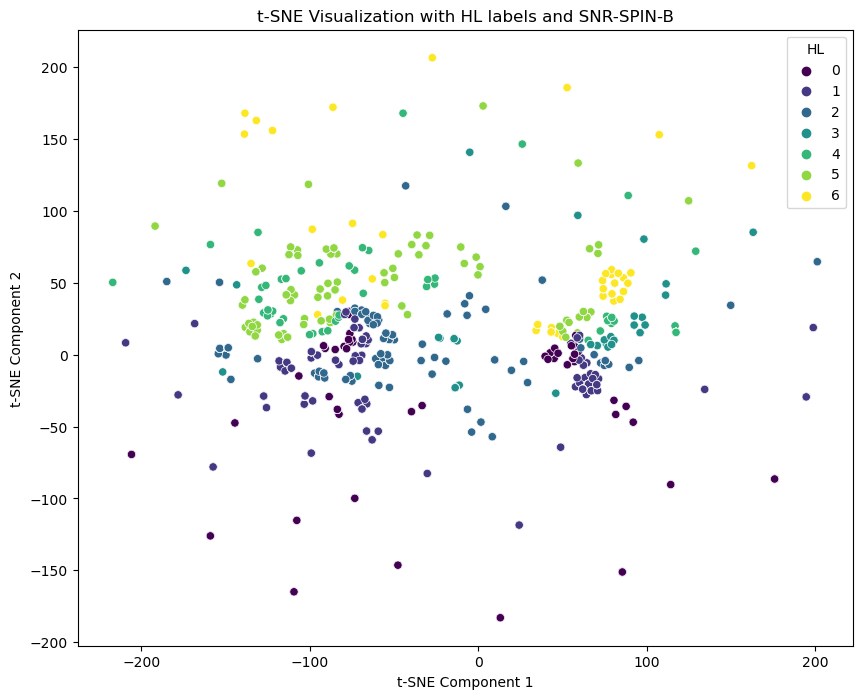

In [419]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'SNR_SPIN_B']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])

# Drop rows with NaN values in 'SNR_SPIN_B' column
new_df.dropna(subset=['HL_encoded', 'SNR_SPIN_B'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'SNR_SPIN_B']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and SNR-SPIN-B')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

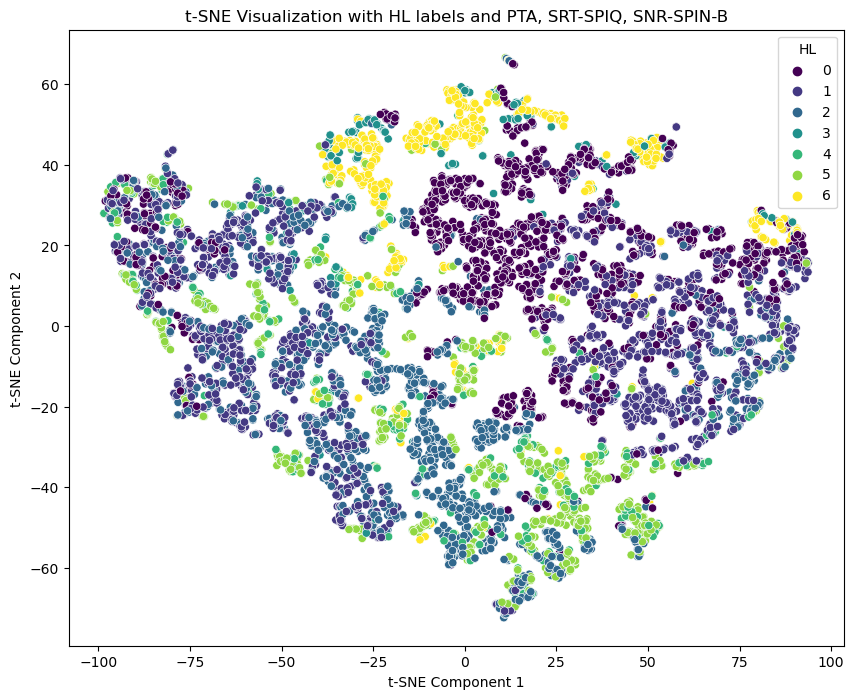

In [420]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'PTA_D', 'SRT_SPIQ_B', 'SNR_SPIN_B']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])

# Drop rows with NaN values in 'PTA_D', 'SRT_SPIQ_B', 'SNR_SPIN_B' column
new_df.dropna(subset=['HL_encoded', 'PTA_D', 'SRT_SPIQ_B', 'SNR_SPIN_B'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'PTA_D', 'SRT_SPIQ_B', 'SNR_SPIN_B']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and PTA, SRT-SPIQ, SNR-SPIN-B')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

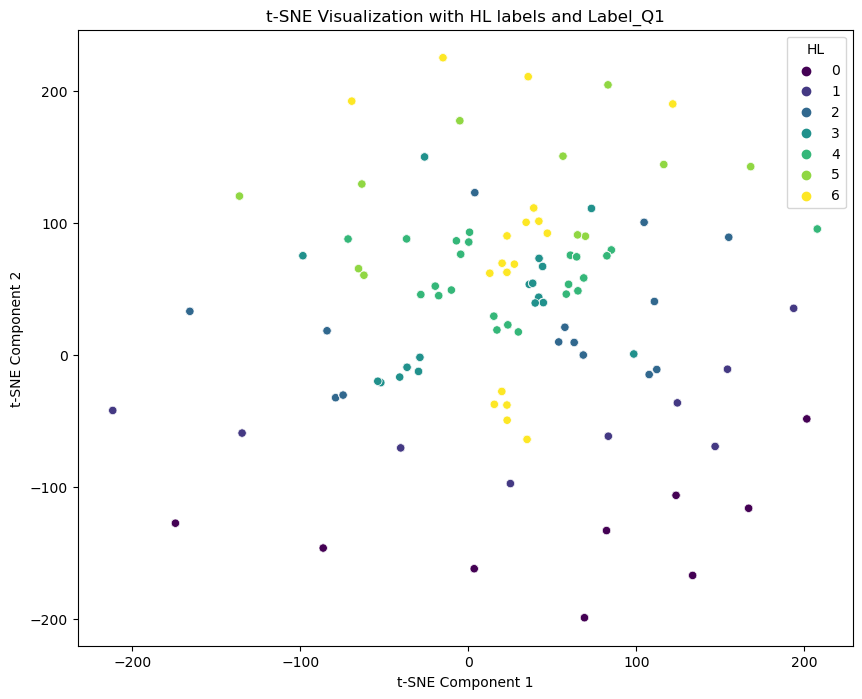

In [422]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'Label_Q1']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])
new_df['Label_Q1_encoded'] = label_encoder.fit_transform(new_df['Label_Q1'])


# Drop rows with NaN values in 'Label_Q1' column
new_df.dropna(subset=['HL_encoded', 'Label_Q1_encoded'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'Label_Q1_encoded']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and Label_Q1')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

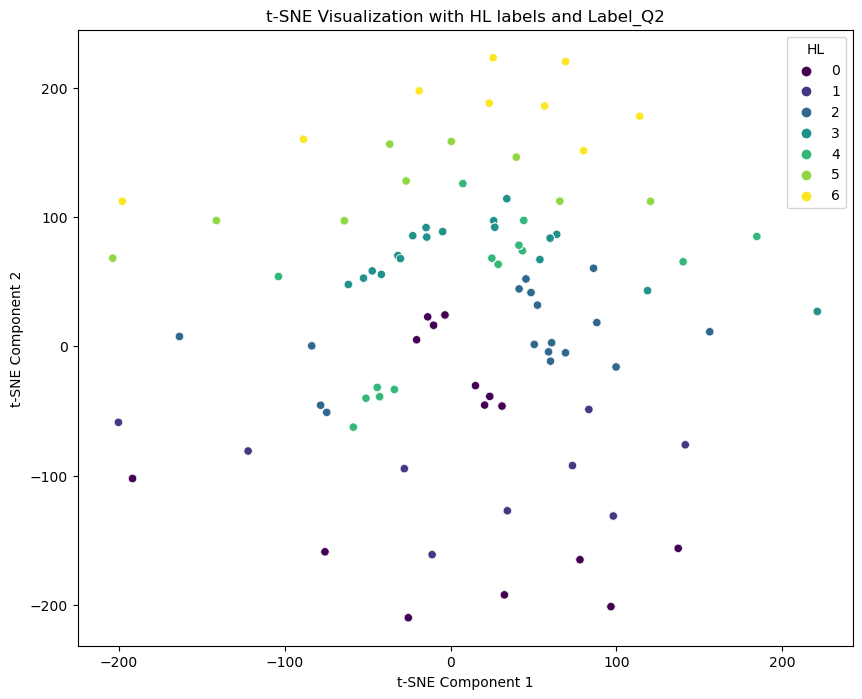

In [424]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'Label_Q2']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])
new_df['Label_Q2_encoded'] = label_encoder.fit_transform(new_df['Label_Q2'])


# Drop rows with NaN values in 'Label_Q1' column
new_df.dropna(subset=['HL_encoded', 'Label_Q2_encoded'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'Label_Q2_encoded']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and Label_Q2')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

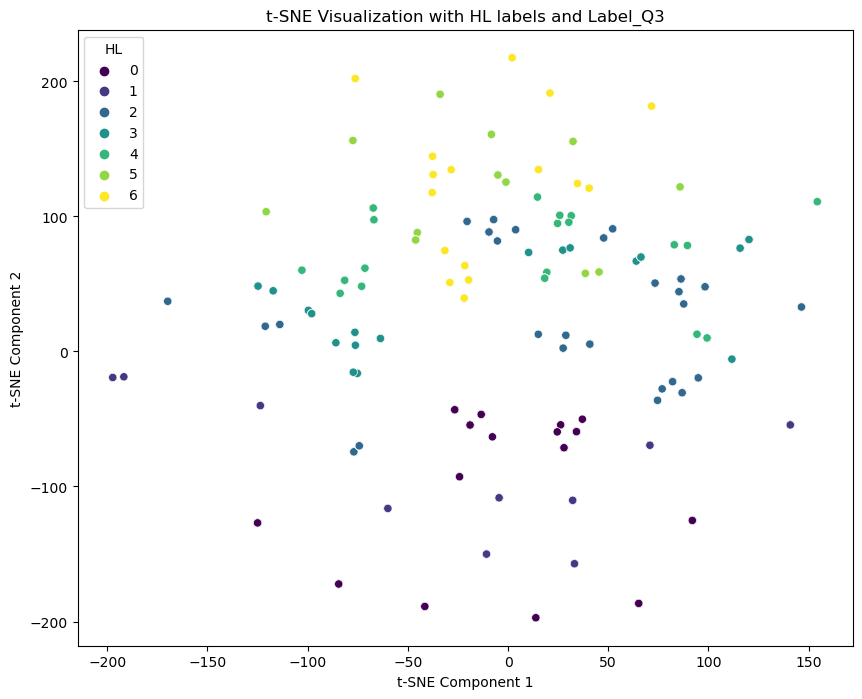

In [425]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'Label_Q3']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])
new_df['Label_Q3_encoded'] = label_encoder.fit_transform(new_df['Label_Q3'])


# Drop rows with NaN values in 'Label_Q1' column
new_df.dropna(subset=['HL_encoded', 'Label_Q3_encoded'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'Label_Q3_encoded']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and Label_Q3')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

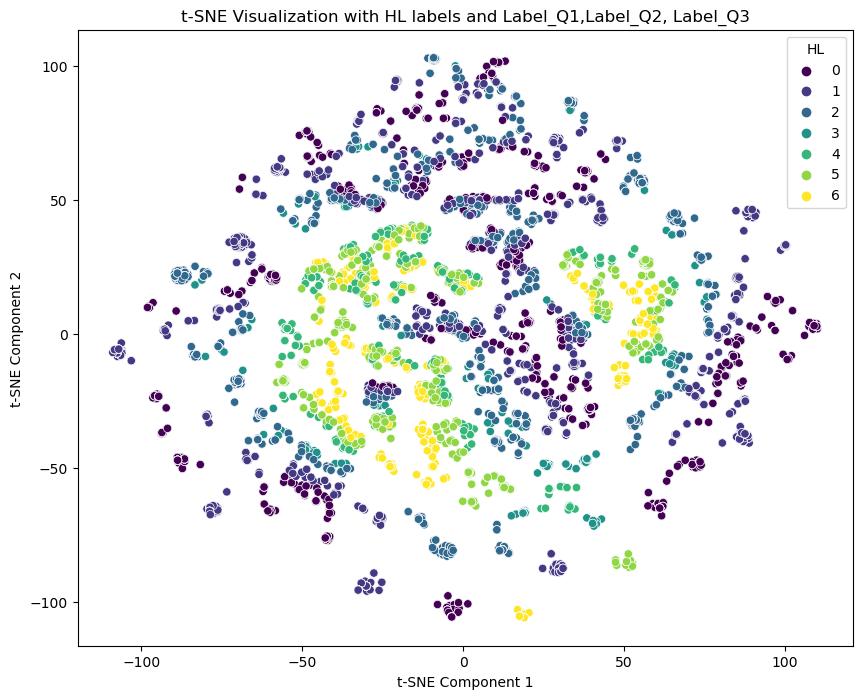

In [426]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'Label_Q1','Label_Q2', 'Label_Q3']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])
new_df['Label_Q1_encoded'] = label_encoder.fit_transform(new_df['Label_Q1'])
new_df['Label_Q2_encoded'] = label_encoder.fit_transform(new_df['Label_Q2'])
new_df['Label_Q3_encoded'] = label_encoder.fit_transform(new_df['Label_Q3'])


# Drop rows with NaN values in 'Label_Q1' column
new_df.dropna(subset=['HL_encoded','Label_Q1_encoded', 'Label_Q2_encoded', 'Label_Q3_encoded'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded',  'Label_Q1_encoded', 'Label_Q2_encoded','Label_Q3_encoded']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and Label_Q1,Label_Q2, Label_Q3')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()

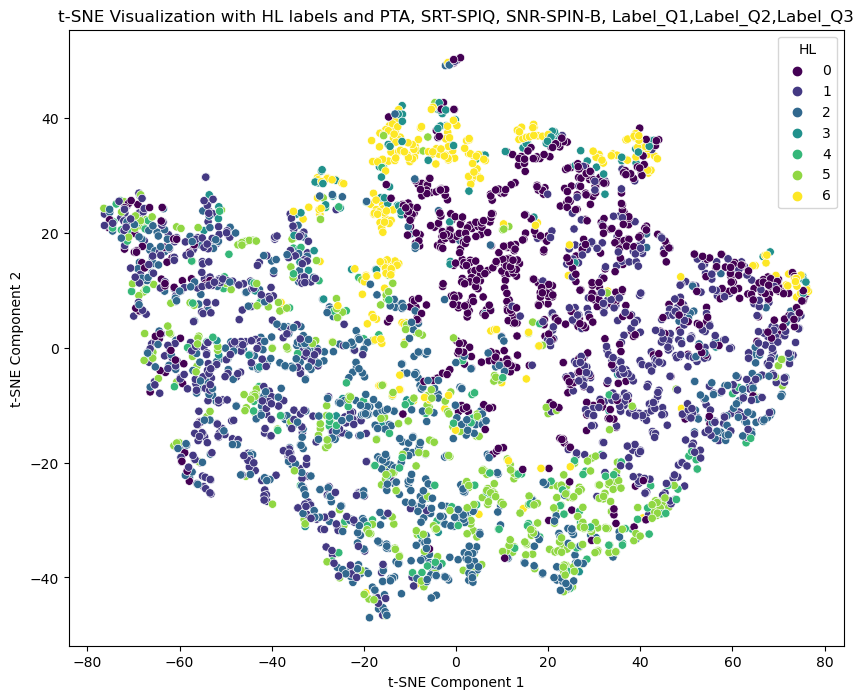

In [433]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Define a new DataFrame with NaN values dropped
new_df = df_false_appareille.dropna(subset=['HL', 'PTA_D', 'SRT_SPIQ_B', 'SNR_SPIN_B','Label_Q1','Label_Q2','Label_Q3']).copy()

# Ensure the changes are applied in place
new_df.reset_index(drop=True, inplace=True)

# Encode the 'HL' column
new_df['HL_encoded'] = label_encoder.fit_transform(new_df['HL'])
new_df['Label_Q1_encoded'] = label_encoder.fit_transform(new_df['Label_Q1'])
new_df['Label_Q2_encoded'] = label_encoder.fit_transform(new_df['Label_Q2'])
new_df['Label_Q3_encoded'] = label_encoder.fit_transform(new_df['Label_Q3'])

# Drop rows with NaN values in 'PTA_D', 'SRT_SPIQ_B', 'SNR_SPIN_B' column
new_df.dropna(subset=['HL_encoded', 'Label_Q1_encoded','Label_Q2_encoded','Label_Q3_encoded','PTA_D', 'SRT_SPIQ_B', 'SNR_SPIN_B'], inplace=True)

# Replace X and y with your data and target variables
X = new_df[['HL_encoded', 'Label_Q1_encoded','Label_Q2_encoded','Label_Q3_encoded', 'PTA_D', 'SRT_SPIQ_B', 'SNR_SPIN_B']].values
y = new_df['HL_encoded'].values

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
X_embedded = tsne.fit_transform(X)

# Visualize the embedded data
plt.figure(figsize=(10, 8))
sn.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization with HL labels and PTA, SRT-SPIQ, SNR-SPIN-B, Label_Q1,Label_Q2,Label_Q3')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='HL')
plt.show()